In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
## Original notebook started with:
# %run setup_PS_data_multi.ipynb  # This notebook loads all data & some packages

## that's replaced here:

## Copied from linear_model.ipynb:L
import popoff
from Session import SessionLite, build_flu_array_single
from mpl_toolkits.mplot3d import Axes3D
from linear_model import PoolAcrossSessions, LinearModel, pca_session, LabelEncoder, largest_PC_trace, largest_PC_loading, do_pca
import loadpaths
from sklearn.metrics import ConfusionMatrixDisplay, roc_curve
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import sys
import os
import pickle
import copy
from scipy import stats, signal
from sklearn.decomposition import PCA
import statsmodels.api as sm
from scipy.stats import lognorm
import warnings

from IPython.core.debugger import Pdb
ipdb = Pdb()

# sys.path.append(os.path.expanduser('~/Documents/code/PtitPrince/pititprince'))
import ptitprince as pt


user_paths_dict = loadpaths.loadpaths()

path_to_vape = user_paths_dict['vape_path']

sys.path.append(str(path_to_vape))
sys.path.append(str(os.path.join(path_to_vape, 'jupyter')))
sys.path.append(str(os.path.join(path_to_vape, 'utils')))

import utils_funcs as utils 

user_paths = loadpaths.loadpaths()
sys.path.append(user_paths['base_path'])
figure_path = '/home/tplas/repos/optistim_results/'
# from pySpatialNeuronNet import factor_analysis


COLORS = [
'#228E5E', # Hit green
'#DB3713', # Miss red
]

warnings.warn('Targets in data, fix self.ever_targetted')
remove_targets = False
pas = PoolAcrossSessions(save_PCA=False, subsample_sessions=False,
                         remove_targets=remove_targets, remove_toosoon = True)
lm = pas.linear_models[0]
print(pas.sessions)

/home/tplas/repos/popping-off/popoff/popoff/loadpaths.py
short post time
short post time
short post time
short post time
short post time
short post time
short post time
ALERT SESSIONS NOT SUBSAMPLED
short post time
short post time
short post time
short post time
short post time
short post time
short post time
{3: instance Mouse J064, run 10 of Session class, 4: instance Mouse J064, run 11 of Session class, 5: instance Mouse J064, run 14 of Session class, 6: instance Mouse RL070, run 28 of Session class, 7: instance Mouse RL070, run 29 of Session class, 2: instance Mouse J063, run 9 of Session class, 1: instance Mouse J065, run 11 of Session class}


In [45]:
## Additional loading 

import pandas as pd
import math, cmath
from tqdm import tqdm
import scipy.stats
import pop_off_functions as pof
import pop_off_plotting as pop
import importlib

In [4]:
try:  # ensure sessions doesn't exist yet 
    sessions
    assert type(sessions) is dict
except NameError:
    pass

sessions = {}
int_keys_pas_sessions = pas.sessions.keys()
print(int_keys_pas_sessions)
assert 0 not in int_keys_pas_sessions # no zero for some reason. change this
for kk in np.sort(np.array(list(int_keys_pas_sessions))):
    sessions[int(kk - 1)] = pas.sessions[kk]
sessions

dict_keys([3, 4, 5, 6, 7, 2, 1])


{0: instance Mouse J065, run 11 of Session class,
 1: instance Mouse J063, run 9 of Session class,
 2: instance Mouse J064, run 10 of Session class,
 3: instance Mouse J064, run 11 of Session class,
 4: instance Mouse J064, run 14 of Session class,
 5: instance Mouse RL070, run 28 of Session class,
 6: instance Mouse RL070, run 29 of Session class}

In [5]:
for kk, ss in sessions.items():
    ss.signature = f'{ss.mouse}_R{ss.run_number}'

In [6]:

print('------------------------------------')
print(f'{len(sessions)} sessions are loaded')

------------------------------------
7 sessions are loaded


In [34]:
ps_acc_split.keys()

dict_keys(['hit', 'fp', 'miss', 'cr'])

In [36]:
## Create list with standard colors:
color_dict_stand = {}
for ii, x in enumerate(plt.rcParams['axes.prop_cycle']()):
    color_dict_stand[ii] = x['color']
    if ii > 8:
        break  # after 8 it repeats (for ever)

colors_plot = {'s1': {lick: 0.6 * np.array(color_dict_stand[lick]) for lick in [0, 1]},
               's2': {lick: 1.1 * np.array(color_dict_stand[lick]) for lick in [0, 1]}}
colors_reg = {reg: 0.5 * (colors_plot[reg][0] + colors_plot[reg][1]) for reg in ['s1', 's2']}

color_tt = {'hit': 'green', 'miss': 'grey', 'fp': 'magenta', 'cr': 'brown', 
            'ur_hit': '#7b85d4', 'ar_miss': '#e9d043'}
label_tt = {'hit': 'Hit', 'miss': 'Miss', 'fp': 'FP', 'cr': 'CR',
            'ur_hit': 'UR Hit', 'ar_miss': 'AR Miss'}
linest_reg = {'s1': '-', 's2': '-'}
label_split = {**{0: 'No L.', 1: 'Lick'}, **label_tt}

for tt in color_tt.keys():
    colors_plot['s1'][tt] = color_tt[tt]
    colors_plot['s2'][tt] = color_tt[tt]


## Integrate different imaging frequencies to create an array of mutual (shared) time points:
freqs = np.unique([ss.frequency for _, ss in sessions.items()])
tp_dict = {}
for ff in freqs:
    for _, ss in sessions.items():   # assume pre_seconds & post_seconds equal for all sessions
        if ss.frequency == ff:
            tp_dict[ff] = ss.filter_ps_time
if len(freqs) == 2:  # for hard-coded bit next up
    tp_dict['mutual'] = np.intersect1d(ar1=tp_dict[freqs[0]], ar2=tp_dict[freqs[1]])
elif len(freqs) == 1:
    tp_dict['mutual'] = tp_dict[freqs[0]]

In [17]:
## To reload the pof module (e.g. after changing a function), run:

# importlib.reload(pof)

In [8]:
# sessions[0].shuffled_s1s2_labels_indicator

# Intro


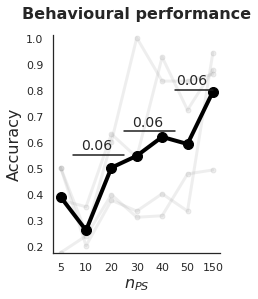

In [21]:
plt.rcParams['figure.figsize'] = (3, 4)
n_ps_arr = [5, 10, 20, 30, 40, 50, 150]
plot_mat_beh = pof.beh_metric(sessions=sessions, metric='accuracy',
                             stim_array=n_ps_arr)  # compute accuracy per session
mouse_list = np.unique([ss.mouse for _, ss in sessions.items()])
mouse_av_beh = np.zeros((len(mouse_list), plot_mat_beh.shape[1]))  # save average accuracy per mouse
for i_m, mouse in enumerate(mouse_list):
    tmp_mouse_list = []
    for i_s, ss in sessions.items():
        if ss.mouse == mouse:
            tmp_mouse_list.append(i_s)
    mouse_av_beh[i_m, :] = np.nanmean(plot_mat_beh[np.array(tmp_mouse_list), :], 0)

## Plot performance per session in heatmap
# plt.subplot(1,2 ,1)
# plt.imshow(plot_mat_beh)
# plt.colorbar()

## Summary plot
ax_perf = plt.subplot(111)
# for i_s in range(plot_mat_beh.shape[0]):  # Plot individual sessions
#     ax_perf.plot(plot_mat_beh[i_s, :], '-', linewidth=3, markersize=14, color='grey', alpha=0.2)
for i_m in range(mouse_av_beh.shape[0]):  # plot individual mice
    ax_perf.plot(mouse_av_beh[i_m, :], '.-', linewidth=3, markersize=10, color='grey', alpha=0.13)
ax_perf.plot(np.nanmean(mouse_av_beh, 0), '.-', linewidth=4, markersize=20, color='black')  # plot average of mouse (almost identical to average of sessions)

## Stat test: one-sided wilcoxon signed-rank test to see if greater n_PS
## lead to greater accuracy. Group per two n_PS (5 & 10) < (20 & 30) < (40 &50) < 150

ax_perf.plot([0.5, 2.5], [0.55, 0.55], color='k')
p_val_low = scipy.stats.wilcoxon(np.mean(mouse_av_beh[:, 0:2], 1), 
                           np.mean(mouse_av_beh[:, 2:4], 1), alternative='less')[1]
ax_perf.text(x=0.8, y=0.57, s=f'{np.round(p_val_low, 2)}', fontdict={'fontsize': 14})

ax_perf.plot([2.5, 4.5], [0.64, 0.64], color='k')
p_val_mid = scipy.stats.wilcoxon(np.mean(mouse_av_beh[:, 2:4], 1), 
                           np.mean(mouse_av_beh[:, 4:6], 1), alternative='less')[1]
ax_perf.text(x=2.8, y=0.66, s=f'{np.round(p_val_mid, 2)}', fontdict={'fontsize': 14})

ax_perf.plot([4.5, 6], [0.8, 0.8], color='k')
p_val_high = scipy.stats.wilcoxon(np.mean(mouse_av_beh[:, 4:6], 1), 
                           mouse_av_beh[:, 6], alternative='less')[1]
ax_perf.text(x=4.55, y=0.82, s=f'{np.round(p_val_high, 2)}', fontdict={'fontsize': 14})

ax_perf.set_xticks(np.arange(len(n_ps_arr))); ax_perf.set_xticklabels(n_ps_arr)
ax_perf.set_ylim([mouse_av_beh.min(), mouse_av_beh.max() + 0.01])
ax_perf.set_xlabel(r"$n_{PS}$", fontdict={'fontsize': 16}); plt.ylabel('Accuracy', fontdict={'fontsize': 16})
ax_perf.set_title('Behavioural performance', y=1.05, weight='bold', fontdict={'fontsize': 16})
sns.despine()
# plt.savefig('figures/intro_fig/beh_perf.pdf', bbox_inches='tight')

In [20]:
## Shuffle data:
bool_shuffle_trials = False
bool_shuffle_s1s2 = False

for ii in range(len(sessions)):
    if bool_shuffle_trials:
        sessions[ii].shuffle_trial_labels()
    if bool_shuffle_s1s2:
        sessions[ii].shuffle_s1s2_labels()

In [22]:
kk = -1

instance Mouse J065, run 11 of Session class

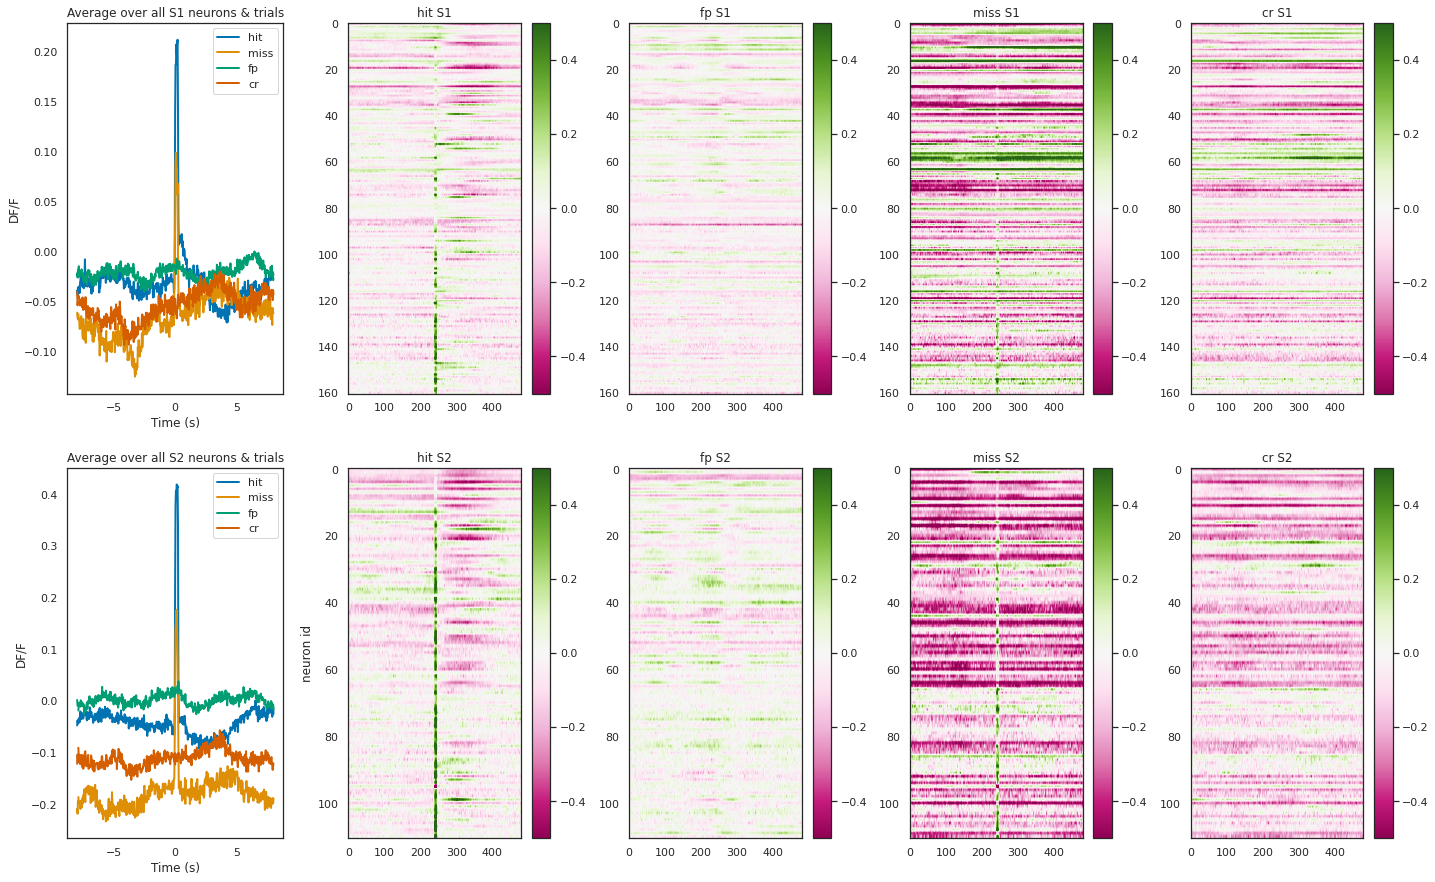

In [23]:
plt.rcParams['figure.figsize']= (24, 15)
plt.subplots_adjust(wspace=0.3)
kk += 1
ax_tmp = plt.subplot(251)
ss = sessions[kk]
for i_x, xx in enumerate(['hit', 'miss', 'fp', 'cr']):
    mean_trace = np.mean(ss.behaviour_trials[:, np.logical_and(ss.outcome == xx, 
                                       ss.photostim < 2), :][:, :, ss.filter_ps_array][ss.s1_bool, :, :], (0, 1))
#     print(np.sum(mean_trace))
    pop.plot_interrupted_trace_simple(ax_tmp, ss.filter_ps_time, mean_trace,
                                      llabel=xx, llinewidth=2, ccolor=color_dict_stand[i_x])
plt.legend(); plt.title('Average over all S1 neurons & trials'); plt.xlabel('Time (s)'); plt.ylabel('DF/F')

ax_tmp = plt.subplot(256)
ss = sessions[kk]
for i_x, xx in enumerate(['hit', 'miss', 'fp', 'cr']):
    mean_trace = np.mean(ss.behaviour_trials[:, np.logical_and(ss.outcome == xx, 
                                       ss.photostim < 2), :][:, :, ss.filter_ps_array][ss.s2_bool, :, :], (0, 1))
#     print(np.sum(mean_trace))
    pop.plot_interrupted_trace_simple(ax_tmp, ss.filter_ps_time, mean_trace,
                                      llabel=xx, llinewidth=2, ccolor=color_dict_stand[i_x])
plt.legend(); plt.title('Average over all S2 neurons & trials'); plt.xlabel('Time (s)'); plt.ylabel('DF/F')

for i_x, xx in enumerate(['hit', 'fp', 'miss', 'cr']):
    plt.subplot(2, 5, (2 + i_x))
    plt.imshow(np.mean(ss.behaviour_trials[:, np.logical_and(ss.outcome == xx, 
                                           ss.photostim < 2), :][:, :, ss.filter_ps_array][ss.s1_bool, :, :], 1), 
#                aspect='auto', vmin=-0.2, vmax=1, cmap='plasma')
                aspect='auto', vmin=-0.5, vmax=0.5, cmap='PiYG')
    plt.colorbar()
    plt.title(xx + ' S1'); #plt.xlabel('Time'); 
    
    plt.subplot(2, 5, (7 + i_x))
    plt.imshow(np.mean(ss.behaviour_trials[:, np.logical_and(ss.outcome == xx, 
                                           ss.photostim < 2), :][:, :, ss.filter_ps_array][ss.s2_bool, :, :], 1), 
#                aspect='auto', vmin=-0.2, vmax=1, cmap='plasma')
                aspect='auto', vmin=-0.5, vmax=0.5, cmap='PiYG')
    plt.colorbar()
    plt.title(xx + ' S2');
    if i_x == 0:
        plt.ylabel('neuron id')

ss

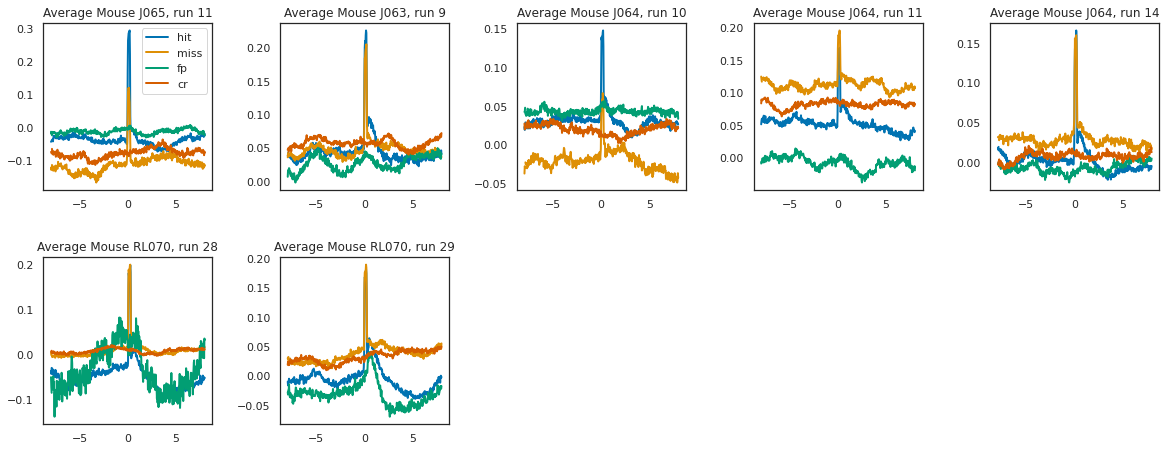

In [29]:
plt.rcParams['figure.figsize'] = (20, 16)
plt.subplots_adjust(wspace=0.4, hspace=0.4)
for kk, ss in sessions.items():
    ax_tmp = plt.subplot(4, 5, kk + 1)
    for i_x, xx in enumerate(['hit', 'miss', 'fp', 'cr']):
        mean_trace = np.mean(ss.behaviour_trials[:, np.logical_and(ss.outcome == xx, 
                                           ss.photostim < 2), :][:, :, ss.filter_ps_array], (0, 1))
        pop.plot_interrupted_trace_simple(ax_tmp, ss.filter_ps_time, mean_trace,
                                          llabel=xx, llinewidth=2, ccolor=color_dict_stand[i_x])
    if kk == 0:
        plt.legend(); 
    plt.title(f'Average {ss.name}');# plt.xlabel('Time (s)'); plt.ylabel('DF/F')


In [28]:
sessions[0].name

'Mouse J065, run 11'

In [33]:
## Compute pre stim window vs post stim window
dict_diff_wind = {name: np.zeros(8 * len(sessions), dtype='object') for name in ['diff_dff', 'region', 'trial_type', 'session']}
ind_data = 0
for _, sess in sessions.items():
    for reg in ['s1', 's2']:
        for tt in ['hit', 'fp', 'miss', 'cr']:
            mean_diff = pof.difference_pre_post(ss=sess, 
                      tt=tt, reg=reg, duration_window=1)
            if len(mean_diff) == 0:
                pass
            else:
                dict_diff_wind['diff_dff'][ind_data] = mean_diff[0]
                dict_diff_wind['region'][ind_data] = reg.upper()
                dict_diff_wind['trial_type'][ind_data] = tt
                dict_diff_wind['session'][ind_data] = sess.signature
                ind_data += 1

            

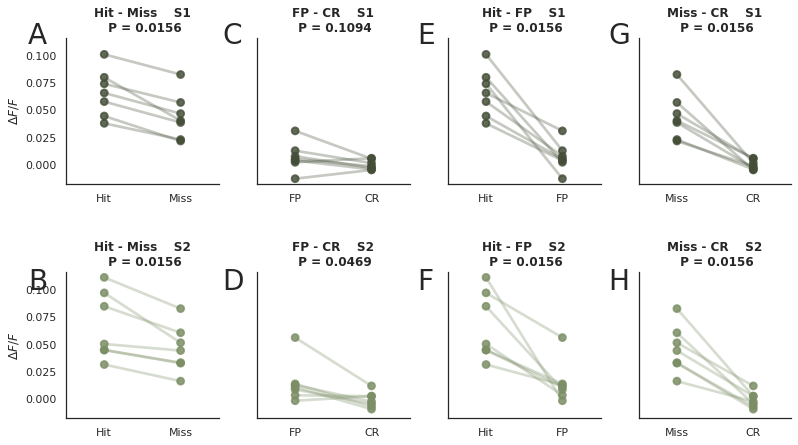

In [34]:
df_differences = pd.DataFrame(dict_diff_wind)
plt.rcParams['figure.figsize'] = (13, 7)
plt.subplots_adjust(wspace=0.25, hspace=0.6)
plot_tt_dict = {0: ['hit', 'miss'], 1: ['fp', 'cr'], 2: ['hit', 'fp'], 3: ['miss', 'cr']}
for i_reg, reg in enumerate(['s1', 's2']):
    for i_comb, tt_comb in plot_tt_dict.items():
        plt.subplot(2, len(plot_tt_dict), 1 + i_comb + (len(plot_tt_dict) * i_reg))
        df_plot = df_differences[np.logical_and(df_differences['region'] == reg.upper(),
                                 np.logical_or(df_differences['trial_type'] == tt_comb[0],
                                               df_differences['trial_type'] == tt_comb[1]))]

        for _, ss in sessions.items(): 
            g = sns.pointplot(data=df_plot[df_plot['session'] == ss.signature],  
                          x='trial_type', y='diff_dff',
                          color=colors_reg[reg])
            plt.setp(g.collections, alpha=.8) #for the markers
            plt.setp(g.lines, alpha=.3)       #for the lines
        p_val = scipy.stats.wilcoxon(df_plot[df_plot['trial_type'] == tt_comb[0]]['diff_dff'],
                             df_plot[df_plot['trial_type'] == tt_comb[1]]['diff_dff'],
                            alternative='two-sided')[1]
        plt.ylim([df_differences['diff_dff'].min() - 0.005, df_differences['diff_dff'].max() + 0.005])
        if i_comb == 0:
            plt.ylabel(r"$\Delta F/F$"); 
        else:
            plt.ylabel(''); g.set_yticklabels('')
        plt.title(f'{label_tt[tt_comb[0]]} - {label_tt[tt_comb[1]]}    {reg.upper()}\n P = {np.round(p_val, 4)}', weight='bold')
        g.set_xticklabels([label_tt[tt_comb[0]], label_tt[tt_comb[1]]]); plt.xlabel('')

plt.text(s='A', x=-8.5, y=0.325, fontdict={'fontsize': 28})
plt.text(s='B', x=-8.5, y=0.1, fontdict={'fontsize': 28})
plt.text(s='C', x=-5.95, y=0.325, fontdict={'fontsize': 28})
plt.text(s='D', x=-5.95, y=0.1, fontdict={'fontsize': 28})
plt.text(s='E', x=-3.4, y=0.325, fontdict={'fontsize': 28})
plt.text(s='F', x=-3.4, y=0.1, fontdict={'fontsize': 28})
plt.text(s='G', x=-0.9, y=0.325, fontdict={'fontsize': 28})
plt.text(s='H', x=-0.9, y=0.1, fontdict={'fontsize': 28})
sns.despine()

#     h = sns.stripplot(data=df_plot, x='trial_type', y='diff_dff',
#               palette='Set1', s=10)
# plt.savefig('figures/s1_s2_static_dff_difference_prestim_poststim_1sec.pdf', bbox_inches='tight')

In [35]:
# list_tp = tp_dict['mutual'][np.where(np.logical_and(tp_dict['mutual'] >= -2, tp_dict['mutual'] <= 5))]
list_tp = tp_dict['mutual'][np.where(tp_dict['mutual'] >= -2)[0]]
list_tt = ['hit', 'fp', 'miss', 'cr', 'ur_hit', 'ar_miss']
# dict_diff = {name: np.zeros(2 * len(list_tt) * len(sessions) * 
#                             len(list_tp), dtype='object') for name in ['diff_dff', 'region', 'trial_type', 'session', 'timepoint', 'new_trial_id']}
ind_data = 0
dict_diff = {name: np.array([]) for name in ['diff_dff', 'region', 'trial_type', 'session', 'timepoint', 'new_trial_id']}  # initiate empy dicts
for _, sess in tqdm(sessions.items()):
    for tp in list_tp:
        for reg in ['s1', 's2']:
            for tt in list_tt:
#                 dict_diff['diff_dff'][ind_data] = pof.difference_pre_post_dynamic(ss=sess, 
#                                           general_tt=tt, reg=reg, duration_window_pre=2, 
#                                           tp_post=tp, odd_tt_only=True)
#                 dict_diff['region'][ind_data] = reg.upper()
#                 dict_diff['trial_type'][ind_data] = tt
#                 dict_diff['session'][ind_data] = sess.signature
#                 dict_diff['timepoint'][ind_data] = tp.copy()
#                 ind_data += 1
                mean_trials = pof.difference_pre_post_dynamic(ss=sess, 
                                          tt=tt, reg=reg, duration_window_pre=2, 
                                          tp_post=tp, return_trials_separate=True)
                if len(mean_trials) == 0:
#                     print(tp, reg, sess, tt ,'   no trials')
                    pass
                else:  # add array of new values
                    dict_diff['diff_dff'] = np.concatenate((dict_diff['diff_dff'], mean_trials))
                    dict_diff['region'] = np.concatenate((dict_diff['region'], [reg.upper() for x in range(len(mean_trials))]))
                    dict_diff['trial_type'] = np.concatenate((dict_diff['trial_type'], [tt for x in range(len(mean_trials))]))
                    dict_diff['session'] = np.concatenate((dict_diff['session'], [sess.signature for x in range(len(mean_trials))]))
                    dict_diff['timepoint'] = np.concatenate((dict_diff['timepoint'], [tp.copy() for x in range(len(mean_trials))]))
                    dict_diff['new_trial_id'] = np.concatenate((dict_diff['new_trial_id'], [ind_data + x for x in range(1, len(mean_trials) + 1)]))  # continuing indices
                    ind_data = dict_diff['new_trial_id'][-1]
dict_diff['timepoint'] = dict_diff['timepoint'].astype('float32')
dict_diff['diff_dff'] = dict_diff['diff_dff'].astype('float32')
df_dyn_differences = pd.DataFrame(dict_diff)


100%|██████████| 7/7 [19:21<00:00, 165.98s/it]


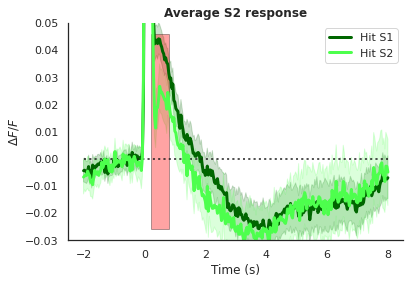

In [38]:
plt.rcParams['figure.figsize'] = (6, 4)
plt.subplots_adjust(hspace=0.4, wspace=0.2)
plot_laser = True
for i_reg, reg in enumerate(['s1', 's2']):
    for i_tt, tt in enumerate(['hit']):
        df_plot = df_dyn_differences[np.logical_and(df_dyn_differences['region'] == reg.upper(),
                                                    df_dyn_differences['trial_type'] == tt)]
        plt.subplot(1, 1,1 )
        if i_reg == 0:
            llabel = label_tt[tt]
        else:
            llabel = label_tt[tt]
        plt.plot([list_tp[0], list_tp[-1]], [0, 0], color='k', linestyle=':', alpha=0.5, linewidth=2)
        if i_reg == 0:
            tmpc = '#006600'
        else:
            tmpc = '#4dff4d'
        sns.lineplot(data=df_plot[df_plot['timepoint'] <= 0], x='timepoint', y='diff_dff', linewidth=3,
                     color=tmpc, label=llabel + f' {reg.upper()}')#, linestyle=linest_reg[reg])
        sns.lineplot(data=df_plot[df_plot['timepoint'] > 0], x='timepoint', y='diff_dff', linewidth=3,
                     color=tmpc, label=None)#, linestyle=linest_reg[reg])
        plt.ylim([-0.03, 0.05])
        plt.title(f'Average {reg.upper()} response', weight='bold');
        if i_reg == 1:
            plt.xlabel('Time (s)'); 
        else:
            plt.xlabel('')
        plt.ylabel(r"$\Delta F/F$")
        if i_reg == 0 and tt == 'miss': # some extra info in left panel
            plt.plot([-2, -2], [0.01, 0.012], color='k')
            plt.plot([0, 0], [0.01, 0.012], color='k')
            plt.plot([-2, 0], [0.012, 0.012], color='k')
            plt.text(s='baseline', x=-2, y=0.0145, fontdict={'fontsize': 10})
            plt.legend(loc='upper right')
        
            
    if plot_laser:  # plot laser
            plt.axvspan(xmin=0.2, xmax=0.8, ymin=0.05, ymax=0.95, 
                        alpha=0.2, label=None, edgecolor='k', facecolor='red')

# plt.xlim([-0.2, 0.4])
sns.despine()
# plt.savefig('figures/s1_s2_dynamic_dff_difference_prestim_poststim_concl4.pdf', bbox_inches='tight')

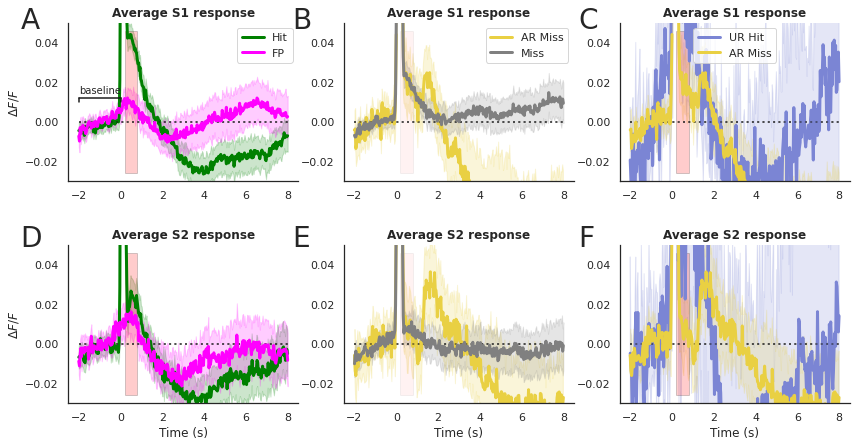

In [40]:
## Custom
plt.rcParams['figure.figsize'] = (14, 7)
plt.subplots_adjust(hspace=0.4, wspace=0.2)
plot_laser = True
for i_reg, reg in enumerate(['s1', 's2']):
    for i_tt, tt in enumerate(['hit', 'fp']):
        df_plot = df_dyn_differences[np.logical_and(df_dyn_differences['region'] == reg.upper(),
                                                    df_dyn_differences['trial_type'] == tt)]
        plt.subplot(2, 3, 1 + i_reg * 3)
        if i_reg == 0:
            llabel = label_tt[tt]
        else:
            llabel = None
        plt.plot([list_tp[0], list_tp[-1]], [0, 0], color='k', linestyle=':', alpha=0.5, linewidth=2)
        sns.lineplot(data=df_plot[df_plot['timepoint'] <= 0], x='timepoint', y='diff_dff', linewidth=3,
                     color=color_tt[tt], label=llabel)#, linestyle=linest_reg[reg])
        sns.lineplot(data=df_plot[df_plot['timepoint'] > 0], x='timepoint', y='diff_dff', linewidth=3,
                     color=color_tt[tt], label=None)#, linestyle=linest_reg[reg])
        plt.ylim([-0.03, 0.05])
        plt.title(f'Average {reg.upper()} response', weight='bold');
        if i_reg == 1:
            plt.xlabel('Time (s)'); 
        else:
            plt.xlabel('')
        plt.ylabel(r"$\Delta F/F$")
        if i_reg == 0 and tt == 'hit': # some extra info in left panel
            plt.plot([-2, -2], [0.01, 0.012], color='k')
            plt.plot([0, 0], [0.01, 0.012], color='k')
            plt.plot([-2, 0], [0.012, 0.012], color='k')
            plt.text(s='baseline', x=-2, y=0.0145, fontdict={'fontsize': 10})
            plt.legend(loc='upper right')
    if plot_laser:  # plot laser
            plt.axvspan(xmin=0.2, xmax=0.8, ymin=0.05, ymax=0.95, 
                        alpha=0.2, label=None, edgecolor='k', facecolor='red')
    
    for i_tt, tt in enumerate(['ar_miss', 'miss']):
        df_plot = df_dyn_differences[np.logical_and(df_dyn_differences['region'] == reg.upper(),
                                                    df_dyn_differences['trial_type'] == tt)]
        plt.subplot(2, 3, 2 + i_reg * 3)
        if i_reg == 0:
            llabel = label_tt[tt]
        else:
            llabel = None
        plt.plot([list_tp[0], list_tp[-1]], [0, 0], color='k', linestyle=':', alpha=0.5, linewidth=2)
        sns.lineplot(data=df_plot[df_plot['timepoint'] <= 0], x='timepoint', y='diff_dff', linewidth=3,
                     color=color_tt[tt], label=llabel)#, linestyle=linest_reg[reg])
        sns.lineplot(data=df_plot[df_plot['timepoint'] > 0], x='timepoint', y='diff_dff', linewidth=3,
                     color=color_tt[tt], label=None)#, linestyle=linest_reg[reg])
        plt.ylim([-0.03, 0.05])
        plt.title(f'Average {reg.upper()} response', weight='bold');
        if i_reg == 1:
            plt.xlabel('Time (s)'); 
        else:
            plt.xlabel('')
        plt.ylabel('')
    if plot_laser:  # plot laser
            plt.axvspan(xmin=0.2, xmax=0.8, ymin=0.05, ymax=0.95, 
                        alpha=0.05, label=None, edgecolor='k', facecolor='red')
            
    for i_tt, tt in enumerate(['ur_hit', 'ar_miss']):
        df_plot = df_dyn_differences[np.logical_and(df_dyn_differences['region'] == reg.upper(),
                                                    df_dyn_differences['trial_type'] == tt)]
        plt.subplot(2, 3, 3 + i_reg * 3)
        if i_reg == 0:
            llabel = label_tt[tt]
        else:
            llabel = None
        plt.plot([list_tp[0], list_tp[-1]], [0, 0], color='k', linestyle=':', alpha=0.5, linewidth=2)
        sns.lineplot(data=df_plot[df_plot['timepoint'] <= 0], x='timepoint', y='diff_dff', linewidth=3,
                     color=color_tt[tt], label=llabel)
        sns.lineplot(data=df_plot[df_plot['timepoint'] > 0], x='timepoint', y='diff_dff', linewidth=3,
                     color=color_tt[tt], label=None)
        plt.ylim([-0.03, 0.05])
        plt.title(f'Average {reg.upper()} response', weight='bold');
        if i_reg == 1:
            plt.xlabel('Time (s)'); 
        else:
            plt.xlabel('')
        plt.ylabel('')
        if i_reg == 0 and tt == 'hit': # some extra info in left panel
            plt.plot([-2, -2], [0.01, 0.012], color='k')
            plt.plot([0, 0], [0.01, 0.012], color='k')
            plt.plot([-2, 0], [0.012, 0.012], color='k')
            plt.text(s='baseline', x=-1.95, y=0.0145)
            plt.legend(loc='upper right')
    if plot_laser:  # plot laser
            plt.axvspan(xmin=0.2, xmax=0.8, ymin=0.05, ymax=0.95, 
                        alpha=0.2, label=None, edgecolor='k', facecolor='red')
    
plt.text(s='A', x=-31.2, y=0.159, fontdict={'weight': 'normal', 'fontsize': 28})
plt.text(s='B', x=-18.2, y=0.159, fontdict={'weight': 'normal', 'fontsize': 28})
plt.text(s='C', x=-4.5, y=0.159, fontdict={'weight': 'normal', 'fontsize': 28})
plt.text(s='D', x=-31.2, y=0.049, fontdict={'weight': 'normal', 'fontsize': 28})
plt.text(s='E', x=-18.2, y=0.049, fontdict={'weight': 'normal', 'fontsize': 28})
plt.text(s='F', x=-4.5, y=0.049, fontdict={'weight': 'normal', 'fontsize': 28})

sns.despine()
# plt.savefig('figures/s1_s2_dynamic_dff_difference_prestim_poststim_concl3.pdf', bbox_inches='tight')

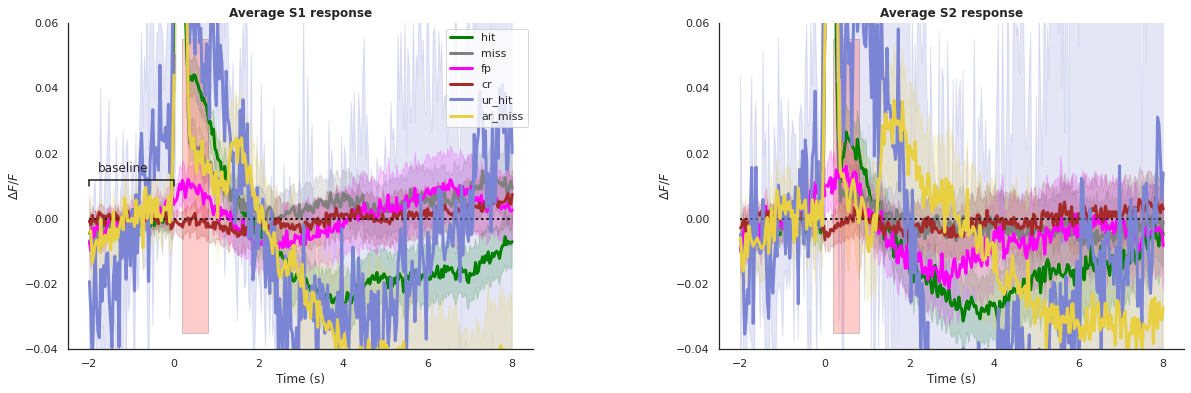

In [39]:
plt.rcParams['figure.figsize'] = (20, 6)
plt.subplots_adjust(wspace=0.4,hspace=0.4)
plot_laser = True
for i_reg, reg in enumerate(['s1', 's2']):
    for i_tt, tt in enumerate(['hit', 'miss', 'fp', 'cr', 'ur_hit', 'ar_miss']):
        df_plot = df_dyn_differences[np.logical_and(df_dyn_differences['region'] == reg.upper(),
                                                    df_dyn_differences['trial_type'] == tt)]
        plt.subplot(1, 2, 1 + i_reg)
        plt.plot([list_tp[0], list_tp[-1]], [0, 0], color='k', linestyle=':', alpha=0.5, linewidth=2)
        if i_reg == 0:
            llabel = tt
        else:
            llabel = None
        sns.lineplot(data=df_plot[df_plot['timepoint'] <= 0], x='timepoint', y='diff_dff', linewidth=3,
                     color=color_tt[tt], label=llabel)
        sns.lineplot(data=df_plot[df_plot['timepoint'] > 0], x='timepoint', y='diff_dff', linewidth=3,
                     color=color_tt[tt], label=None)
        plt.ylim([-0.04, 0.06])
        
    if plot_laser:  # plot laser
            plt.axvspan(xmin=0.2, xmax=0.8, ymin=0.05, ymax=0.95, alpha=0.2, 
                        label=None, edgecolor='k', facecolor='red')
    if i_reg == 0: # some extra info in left panel
        plt.plot([-2, -2], [0.01, 0.012], color='k')
        plt.plot([0, 0], [0.01, 0.012], color='k')
        plt.plot([-2, 0], [0.012, 0.012], color='k')
        plt.text(s='baseline', x=-1.8, y=0.0145)
        plt.legend(loc='upper right')
    
    plt.title(f'Average {reg.upper()} response', weight='bold');
    plt.xlabel('Time (s)'); plt.ylabel(r"$\Delta F/F$")
# plt.suptitle('ONLY UNREWARDED HIT & AUTOREWARDED MISS TRIALS', y=1.04)
sns.despine()
# plt.savefig('figures/s1_s2_dynamic_dff_difference_prestim_poststim_tmp.pdf', bbox_inches='tight')

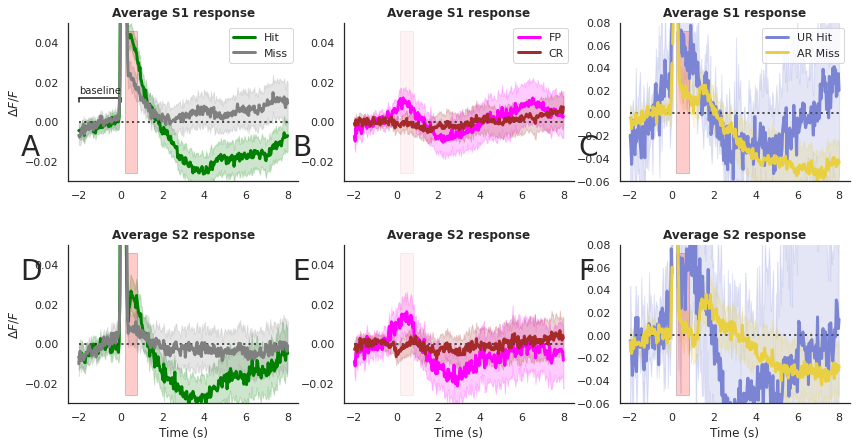

In [104]:
plt.rcParams['figure.figsize'] = (14, 7)
plt.subplots_adjust(hspace=0.4, wspace=0.2)
plot_laser = True
for i_reg, reg in enumerate(['s1', 's2']):
    for i_tt, tt in enumerate(['hit', 'miss']):
        df_plot = df_dyn_differences[np.logical_and(df_dyn_differences['region'] == reg.upper(),
                                                    df_dyn_differences['trial_type'] == tt)]
        plt.subplot(2, 3, 1 + i_reg * 3)
        if i_reg == 0:
            llabel = label_tt[tt]
        else:
            llabel = None
        plt.plot([list_tp[0], list_tp[-1]], [0, 0], color='k', linestyle=':', alpha=0.5, linewidth=2)
        sns.lineplot(data=df_plot[df_plot['timepoint'] <= 0], x='timepoint', y='diff_dff', linewidth=3,
                     color=color_tt[tt], label=llabel)#, linestyle=linest_reg[reg])
        sns.lineplot(data=df_plot[df_plot['timepoint'] > 0], x='timepoint', y='diff_dff', linewidth=3,
                     color=color_tt[tt], label=None)#, linestyle=linest_reg[reg])
        plt.ylim([-0.03, 0.05])
        plt.title(f'Average {reg.upper()} response', weight='bold');
        if i_reg == 1:
            plt.xlabel('Time (s)'); 
        else:
            plt.xlabel('')
        plt.ylabel(r"$\Delta F/F$")
        if i_reg == 0 and tt == 'hit': # some extra info in left panel
            plt.plot([-2, -2], [0.01, 0.012], color='k')
            plt.plot([0, 0], [0.01, 0.012], color='k')
            plt.plot([-2, 0], [0.012, 0.012], color='k')
            plt.text(s='baseline', x=-2, y=0.0145, fontdict={'fontsize': 10})
            plt.legend(loc='upper right')
    if plot_laser:  # plot laser
            plt.axvspan(xmin=0.2, xmax=0.8, ymin=0.05, ymax=0.95, 
                        alpha=0.2, label=None, edgecolor='k', facecolor='red')
    
    for i_tt, tt in enumerate(['fp', 'cr']):
        df_plot = df_dyn_differences[np.logical_and(df_dyn_differences['region'] == reg.upper(),
                                                    df_dyn_differences['trial_type'] == tt)]
        plt.subplot(2, 3, 2 + i_reg * 3)
        if i_reg == 0:
            llabel = label_tt[tt]
        else:
            llabel = None
        plt.plot([list_tp[0], list_tp[-1]], [0, 0], color='k', linestyle=':', alpha=0.5, linewidth=2)
        sns.lineplot(data=df_plot[df_plot['timepoint'] <= 0], x='timepoint', y='diff_dff', linewidth=3,
                     color=color_tt[tt], label=llabel)#, linestyle=linest_reg[reg])
        sns.lineplot(data=df_plot[df_plot['timepoint'] > 0], x='timepoint', y='diff_dff', linewidth=3,
                     color=color_tt[tt], label=None)#, linestyle=linest_reg[reg])
        plt.ylim([-0.03, 0.05])
        plt.title(f'Average {reg.upper()} response', weight='bold');
        if i_reg == 1:
            plt.xlabel('Time (s)'); 
        else:
            plt.xlabel('')
        plt.ylabel('')
    if plot_laser:  # plot laser
            plt.axvspan(xmin=0.2, xmax=0.8, ymin=0.05, ymax=0.95, 
                        alpha=0.05, label=None, edgecolor='k', facecolor='red')
            
    for i_tt, tt in enumerate(['ur_hit', 'ar_miss']):
        df_plot = df_dyn_differences[np.logical_and(df_dyn_differences['region'] == reg.upper(),
                                                    df_dyn_differences['trial_type'] == tt)]
        plt.subplot(2, 3, 3 + i_reg * 3)
        if i_reg == 0:
            llabel = label_tt[tt]
        else:
            llabel = None
        plt.plot([list_tp[0], list_tp[-1]], [0, 0], color='k', linestyle=':', alpha=0.5, linewidth=2)
        sns.lineplot(data=df_plot[df_plot['timepoint'] <= 0], x='timepoint', y='diff_dff', linewidth=3,
                     color=color_tt[tt], label=llabel)
        sns.lineplot(data=df_plot[df_plot['timepoint'] > 0], x='timepoint', y='diff_dff', linewidth=3,
                     color=color_tt[tt], label=None)
        plt.ylim([-0.06, 0.08])
        plt.title(f'Average {reg.upper()} response', weight='bold');
        if i_reg == 1:
            plt.xlabel('Time (s)'); 
        else:
            plt.xlabel('')
        plt.ylabel('')
        if i_reg == 0 and tt == 'hit': # some extra info in left panel
            plt.plot([-2, -2], [0.01, 0.012], color='k')
            plt.plot([0, 0], [0.01, 0.012], color='k')
            plt.plot([-2, 0], [0.012, 0.012], color='k')
            plt.text(s='baseline', x=-1.95, y=0.0145)
            plt.legend(loc='upper right')
    if plot_laser:  # plot laser
            plt.axvspan(xmin=0.2, xmax=0.8, ymin=0.05, ymax=0.95, 
                        alpha=0.2, label=None, edgecolor='k', facecolor='red')
    
plt.text(s='A', x=-31.2, y=0.159, fontdict={'weight': 'normal', 'fontsize': 28})
plt.text(s='B', x=-18.2, y=0.159, fontdict={'weight': 'normal', 'fontsize': 28})
plt.text(s='C', x=-4.5, y=0.159, fontdict={'weight': 'normal', 'fontsize': 28})
plt.text(s='D', x=-31.2, y=0.049, fontdict={'weight': 'normal', 'fontsize': 28})
plt.text(s='E', x=-18.2, y=0.049, fontdict={'weight': 'normal', 'fontsize': 28})
plt.text(s='F', x=-4.5, y=0.049, fontdict={'weight': 'normal', 'fontsize': 28})

sns.despine()
# plt.savefig('figures/s1_s2_dynamic_dff_difference_prestim_poststim_full.pdf', bbox_inches='tight')

In [103]:
ss.post_gap_seconds

0

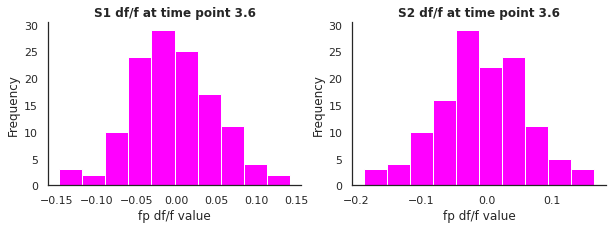

In [66]:
## Inspect data:
df = df_dyn_differences
tp = 3.6
tt = 'fp'
assert tp in np.unique(df['timepoint'])
assert tt in np.unique(df['trial_type'])
assert 'S1' in np.unique(df['region'])
assert 'S2' in np.unique(df['region'])
plt.rcParams['figure.figsize'] = (10, 3)
for i_reg, reg in enumerate(['s1', 's2']):
    plt.subplot(1, 2, 1 + i_reg)
    plt.hist(df[np.logical_and(df['trial_type'] == tt, np.logical_and(np.isclose(df['timepoint'], tp),
                               df['region'] == reg.upper()))]['diff_dff'],
            color=color_tt['fp'])
    plt.xlabel(f'{tt} df/f value'); plt.ylabel('Frequency'); 
    plt.title(f'{reg.upper()} df/f at time point {tp}', weight='bold');
sns.despine()

## Single time point decoder example:

Mouse J064, Starting loop 1/1


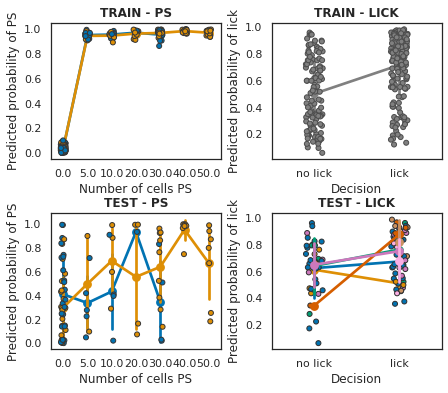

In [14]:
time_frame = 1.2
n_splits = 4
ss_dict = {0: sessions[2]}

df_prediction_train, df_prediction_test, tmp = pof.train_test_all_sessions(sessions=ss_dict, verbose=1, n_split=n_splits,
                                              trial_times_use=np.array([time_frame]), return_decoder_weights=True,
                                         hitmiss_only=False,# list_test=['dec', 'stim'],
                                         include_autoreward=True, neurons_selection='s1',
                                         C_value=50, train_projected=True, proj_dir='same')

plt.rcParams['figure.figsize'] = (7, 6)
plt.subplots_adjust(wspace=0.3, hspace=0.4)
    
## NB: To not plot with hue, set hh=None
# for mouse in df_prediction_train.keys():
for mouse in [ss_dict[0].mouse]:
    if 'pred_stim_train' in df_prediction_train[mouse].columns:
        plt.subplot(221)
        pop.plot_df_stats(df=df_prediction_train[mouse], xx='true_stim_train', yy='pred_stim_train_proj', hh='true_dec_train')  # set hh=None or hh='dec_train'
        plt.xlabel('Number of cells PS'); plt.ylabel('Predicted probability of PS'); plt.title('TRAIN - PS', weight='bold')
        plt.legend([], frameon=False)

        plt.subplot(223)
        pop.plot_df_stats(df=df_prediction_test[mouse], xx='true_stim_test', yy='pred_stim_test_proj', hh='true_dec_test')  # set hh=None or hh='dec_test'
        plt.xlabel('Number of cells PS'); plt.ylabel('Predicted probability of PS'); plt.title('TEST - PS', weight='bold')
        plt.legend([], frameon=False)
#         print(f'Accuracy PS: {pof.class_av_mean_accuracy(binary_truth=(df_prediction_test[mouse]["true_stim_test"] > 0).astype("int"), estimate=df_prediction_test[mouse]["pred_stim_test_proj"])[0]}')
        
    if 'pred_dec_train' in df_prediction_train[mouse].columns:  
        plt.subplot(222)
        pop.plot_df_stats(df=df_prediction_train[mouse], xx='true_dec_train', yy='pred_dec_train_proj', hh=None, xticklabels=['no lick', 'lick'])
        plt.xlabel('Decision'); plt.ylabel('Predicted probability of lick'); plt.title('TRAIN - LICK', weight='bold')
        plt.legend('No lick', 'lick', frameon=False)

        plt.subplot(224)
        pop.plot_df_stats(df=df_prediction_test[mouse], xx='true_dec_test', yy='pred_dec_test_proj', hh='true_stim_test', xticklabels=['no lick', 'lick'], type_scatter='strip')
        plt.xlabel('Decision'); plt.ylabel('Predicted probability of lick'); plt.title('TEST - LICK', weight='bold');
        plt.legend([], frameon=False)
#         print(f'Accuracy lick: {pof.class_av_mean_accuracy(binary_truth=df_prediction_test[mouse]["true_dec_test"], estimate=df_prediction_test[mouse]["pred_dec_test_proj"])[0]}')
# plt.suptitle(f'(Logistic Regression) decoding performance for frame {time_frame}: \n{[str(sessions[x]) for x in range(len(sessions))]}\n' + 
# #              f'Left column shows Photostimulation (PS) decoding performance, right column shows lick decoding\n' +
#              f'Top row shows train data; bottom row shows test data, {n_splits} splits\n');

In [19]:
(df_prediction_test['J064']['outcome_test']).copy()

0     miss
1      hit
2     miss
3       fp
4       cr
      ... 
90      cr
91    miss
92    miss
93      cr
94      cr
Name: outcome_test, Length: 95, dtype: object

In [6]:
## Inspect influence autorewards:
# mouse = 'J048'
# print(df_prediction_test[mouse][np.logical_and(df_prediction_test[mouse]['autorewarded_test'] == 1,
#                                                df_prediction_test[mouse]['true_stim_test'] > 0)]['pred_dec_test'].mean())

# print(df_prediction_test[mouse][np.logical_and(df_prediction_test[mouse]['autorewarded_test'] == 0,
#                                                df_prediction_test[mouse]['true_stim_test'] > 0)]['pred_dec_test'].mean())

# print(df_prediction_test[mouse][df_prediction_test[mouse]['true_stim_test'] > 0 ]['pred_dec_test'].mean())

## Check single neurons

In [68]:
dw = decoder_weights['s1_stim']['J048_R29']
dw_as = np.argsort(np.sum(dw, 1))[::-1]

plt.rcParams['figure.figsize'] = (8, 8)
plt.imshow(dw[dw_as, :], aspect='auto', cmap='PiYG', vmin=-0.5, vmax=0.5)
plt.colorbar()
# plt.plot(np.mean(np.abs(dw[dw_as[900:], :]), 0))

dw_as[300]

NameError: name 'decoder_weights' is not defined

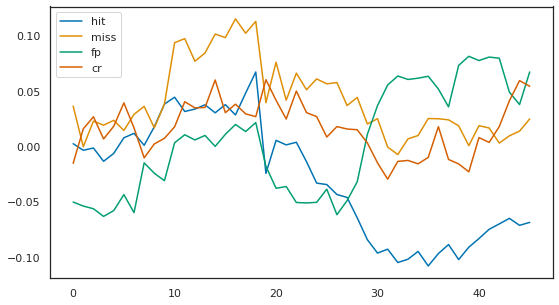

In [12]:
s2_inds = np.where(sessions[2].s1_bool)[0]
plt.rcParams['figure.figsize'] = (9, 5)
neuron_data = sessions[2].behaviour_trials[s2_inds[dw_as[6]], :,:][:, sessions[2].filter_ps_array]
for tt in ['hit', 'miss', 'fp', 'cr']:
    plt.plot(np.mean(neuron_data[sessions[2].outcome == tt, :], 0), label=tt)
# for tt in [0, 1]:
#     plt.plot(np.mean(neuron_data[sessions[2].decision == tt, :], 0), label=tt)

plt.legend()

## Train dynamic decoders:

In [20]:
tp_dict['decoders'] = tp_dict['mutual']#[np.logical_and(tp_dict['mutual'] >-2]#, tp_dict['mutual'] <= 4)]
new_time = tp_dict['decoders']

In [29]:
## Compute results decoders (note: CV of regularisation is down below in the notebook)
(lick_acc, lick_acc_split, ps_acc, ps_acc_split, lick_half, 
     angle_dec, decoder_weights) = pof.compute_accuracy_time_array_average_per_mouse(sessions=sessions, 
                                               time_array=tp_dict['decoders'],
                                              projected_data=False, 
                                              reg_type='l2', regularizer=50,  #reg_type='none',
                                              average_fun=pof.class_av_mean_accuracy,
                                              split_fourway=True)

480it [11:49,  1.48s/it]


In [39]:
## Which time points to include in violin plots:
tp_list = [1.0, 4.0]  # in seconds

region_list = ['s1', 's2']
dict_df_test = {reg: {} for reg in region_list}
for reg in region_list:
    for tp in tp_list:  # retrain (deterministic) decoders for these time points, and save detailed info
        _, dict_df_test[reg][tp] = pof.train_test_all_sessions(sessions=sessions, verbose=0,# n_split=n_split,
                                     trial_times_use=np.array([tp]), return_decoder_weights=False,
                                     hitmiss_only=False,# list_test=['dec', 'stim'],
                                     include_autoreward=False, neurons_selection=reg,
                                     C_value=50, reg_type='l2', train_projected=False)

## turn into df that can be used for violin plots efficiently,
## normalised so that each animals is equally important in averaging
violin_df_test = pof.make_violin_df_custom(input_dict_df=dict_df_test, 
                                           flat_normalise_ntrials=True, verbose=1) 
tp_violin = list(violin_df_test.keys())

Number of trials for mouse J063: 107, multiplications: 93.46
Number of trials for mouse J064: 299, multiplications: 33.44
Number of trials for mouse J065: 101, multiplications: 99.01
Number of trials for mouse RL070: 319, multiplications: 31.35
Corrected number of trials for mouse J063: 19902
Corrected number of trials for mouse J064: 19734
Corrected number of trials for mouse J065: 19998
Corrected number of trials for mouse RL070: 19778


## Create PS decoding summary plot

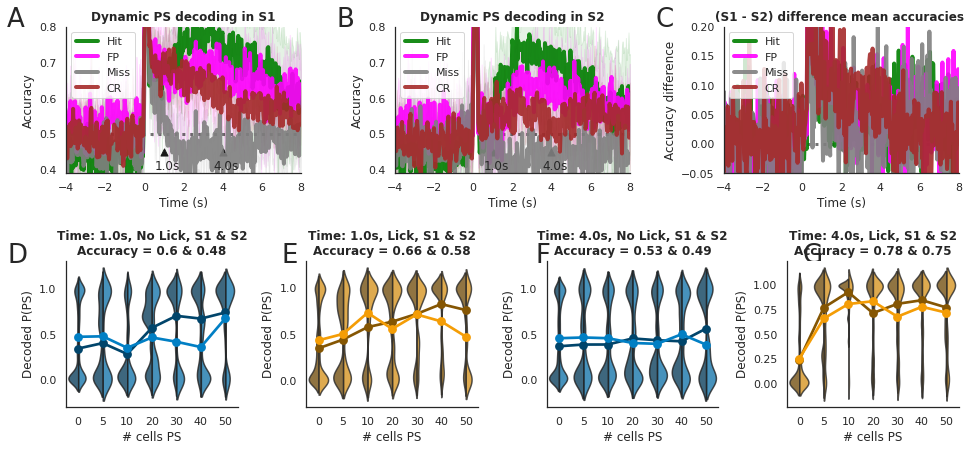

In [46]:
## PS decoding figure
plt.rcParams['figure.figsize'] = (16, 7)
plt.subplots_adjust(wspace=0.4, hspace=0.6)
p_val_thresh = 0.05  # P val for wilcoxon sr test.

# new_time = 
## Average S1 & S2
# plot_interrupted_trace_average_per_mouse(ax=ax_acc_ps2,  time_array=new_time, plot_array=ps_acc, plot_indiv=False,
#                        llabel='Average', ccolor=color_dict_stand[7])  # average between regions

## S1 figure:
# ax_acc_ps1 = plt.subplot(4, 2, (1, 3))
ax_acc_ps1 = plt.subplot(2, 3, 1)
pop.plot_interrupted_trace_simple(ax=ax_acc_ps1, time_array=new_time, 
                                  plot_array=np.zeros_like(new_time) + 0.5, 
                                  ccolor='k', aalpha=0.6, llinewidth=3, linest=':')
for i_lick, dict_part in ps_acc_split.items():  # PS accuracy split per lick /no lick trials
    pop.plot_interrupted_trace_average_per_mouse(ax=ax_acc_ps1, time_array=new_time, plot_array=dict_part, llabel=label_split[i_lick], 
                           ccolor=colors_plot['s1'][i_lick], plot_indiv=False, plot_laser=False, #i_lick, 
                           plot_errorbar=False, plot_std_area=True, region_list=['s1'])
for tp in tp_violin:
    ax_acc_ps1.scatter([tp], [.45], marker='^', s=50, color='k')
    ax_acc_ps1.text(s=f'{tp}s', x=tp - 0.45, y=0.4)
ax_acc_ps1.set_xlabel('Time (s)'); ax_acc_ps1.set_ylabel('Accuracy')
ax_acc_ps1.legend(loc='upper left'); ax_acc_ps1.set_title('Dynamic PS decoding in S1', weight='bold')
ax_acc_ps1.set_ylim([0.39, 0.8])

## S2 figure:
# ax_acc_ps2 = plt.subplot(4, 2, (2, 4))
ax_acc_ps2 = plt.subplot(2, 3, 2)
pop.plot_interrupted_trace_simple(ax=ax_acc_ps2, time_array=new_time, 
                                  plot_array=np.zeros_like(new_time) + 0.5, 
                              ccolor='k', aalpha=0.6, llinewidth=3, linest=':')
for i_lick, dict_part in ps_acc_split.items():  # PS accuracy split per lick /no lick trials
    pop.plot_interrupted_trace_average_per_mouse(ax=ax_acc_ps2, time_array=new_time, plot_array=dict_part, llabel=label_split[i_lick], 
                           ccolor=colors_plot['s2'][i_lick], plot_indiv=False, plot_laser=False, #i_lick, 
                           plot_errorbar=False, plot_std_area=True, region_list=['s2'])
for tp in tp_violin:
    ax_acc_ps2.scatter([tp], [.45], marker='^', s=50, color='k')
    ax_acc_ps2.text(s=f'{tp}s', x=tp - 0.45, y=0.4)
ax_acc_ps2.set_xlabel('Time (s)'); ax_acc_ps2.set_ylabel('Accuracy')
ax_acc_ps2.legend(loc='upper left'); ax_acc_ps2.set_title('Dynamic PS decoding in S2', weight='bold')
ax_acc_ps2.set_ylim([0.39, 0.8])

## S1/S2 difference fig:
# ax_diff = plt.subplot(4, 2, ((5, 7)))
ax_diff = plt.subplot(2, 3, 3)
pop.plot_interrupted_trace_simple(ax=ax_diff, time_array=new_time, 
                                  plot_array=np.zeros_like(new_time), 
                              ccolor='k', aalpha=0.6, llinewidth=3, linest=':')
for i_lick, dict_part in ps_acc_split.items():  # PS accuracy split per lick /no lick trials
    pop.plot_interrupted_trace_average_per_mouse(ax=ax_diff, time_array=new_time, plot_array=dict_part, llabel=label_split[i_lick], 
                           ccolor=colors_plot['s1'][i_lick], plot_indiv=False, plot_laser=False, #i_lick, 
                           plot_errorbar=False, plot_std_area=False, region_list=['s1', 's2'], plot_diff_s1s2=True)
    p_vals_wsr = pof.wilcoxon_test(dict_part)
    inds_sign = np.where(p_vals_wsr < p_val_thresh)[0]
#     ax_diff.scatter(new_time[inds_sign], np.zeros_like(inds_sign) + .17 + (i_lick * 0.015), marker='*', s=60, color=color_dict_stand[i_lick])
ax_diff.set_xlabel('Time (s)'); ax_diff.set_ylabel('Accuracy difference')
ax_diff.legend(loc='upper left'); ax_diff.set_title('(S1 - S2) difference mean accuracies ', weight='bold')
ax_diff.set_ylim([-0.05, 0.2])

for ax in [ax_acc_ps1, ax_acc_ps2, ax_diff]:
    ax.set_xlim([-4, 8])


## Violin plots
lick_title = {0: 'No Lick', 1: 'Lick'}
for i_tp, tp in enumerate(tp_violin):
    for lick in [0, 1]:
#         plt.subplot(4, 4, 11 + i_tp + 4 * lick)
        plt.subplot(2, 4, 5 + lick + 2 * i_tp)
        plot_df = violin_df_test[tp][violin_df_test[tp]['true_dec_test'] == lick]
        viol = sns.violinplot(data=plot_df, x='true_stim_test', y='pred_stim_test',
                       palette=[0.6 * np.array(color_dict_stand[lick]), 1.1 * np.array(color_dict_stand[lick])],
                       hue='region', split=True, inner=None)
        plt.setp(viol.collections, alpha=0.8)
        tmp = sns.pointplot(data=plot_df, x='true_stim_test', y='pred_stim_test',
                       palette=[0.6 * np.array(color_dict_stand[lick]), 1.1 * np.array(color_dict_stand[lick])],
                       hue='region', label=None, linestyles=[linest_reg['s1'], linest_reg['s2']], estimator=np.mean)
        accuracy_tp_s1 = pof.class_av_mean_accuracy(binary_truth=(plot_df[plot_df['region'] == 'S1']['true_stim_test'] > 0).astype('int'),
                           estimate=plot_df[plot_df['region'] == 'S1']['pred_stim_test'])[0]
        accuracy_tp_s2 = pof.class_av_mean_accuracy(binary_truth=(plot_df[plot_df['region'] == 'S2']['true_stim_test'] > 0).astype('int'),
                           estimate=plot_df[plot_df['region'] == 'S2']['pred_stim_test'])[0]
        
        plt.title(f'Time: {tp}s, {lick_title[lick]}, S1 & S2\nAccuracy = {np.round(accuracy_tp_s1, 2)} & {np.round(accuracy_tp_s2, 2)}', weight='bold')
        viol.legend_.remove();
        plt.xlabel('# cells PS'); plt.ylabel('Decoded P(PS)')
        viol.set_xticklabels([0, 5, 10, 20, 30, 40, 50])
## Labels:
ax_acc_ps1.text(s='A', x=-7, y=0.8, fontdict={'weight': 'normal', 'fontsize': 26})
ax_acc_ps2.text(s='B', x=-7, y=0.8, fontdict={'weight': 'normal', 'fontsize': 26})
ax_diff.text(s='C', x=-7.5, y=0.2, fontdict={'weight': 'normal', 'fontsize': 26})
ax_acc_ps1.text(s='D', x=-7, y=0.14, fontdict={'weight': 'normal', 'fontsize': 26})
ax_acc_ps1.text(s='E', x=7, y=0.14, fontdict={'weight': 'normal', 'fontsize': 26})
ax_acc_ps1.text(s='F', x=20, y=0.14, fontdict={'weight': 'normal', 'fontsize': 26})
ax_acc_ps1.text(s='G', x=33.6, y=0.14, fontdict={'weight': 'normal', 'fontsize': 26})
sns.despine()
# plt.savefig('figures/decoding_ps.pdf', bbox_inches='tight')

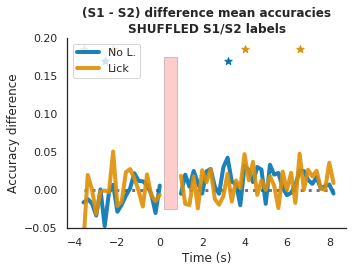

In [24]:
## Same plot as previous figure panel C; to only show difference in case of shuffled labels

## NB: THIS MUST BE DONE BY SHUFFLING THE DATA BEFOREHAND (SEE TOP OF NB)

plt.rcParams['figure.figsize'] =(5, 3.5)
p_val_thresh = 0.05
ax_diff = plt.subplot(111)
pop.plot_interrupted_trace_simple(ax=ax_diff, time_array=new_time, plot_array=np.zeros_like(new_time), 
                              ccolor='k', aalpha=0.6, llinewidth=3, linest=':')
for i_lick, dict_part in ps_acc_split.items():  # PS accuracy split per lick /no lick trials
    pop.plot_interrupted_trace_average_per_mouse(ax=ax_diff, time_array=new_time, plot_array=dict_part, llabel=label_split[i_lick], 
                           ccolor=color_dict_stand[i_lick], plot_indiv=False, plot_laser=i_lick, 
                           plot_errorbar=False, plot_std_area=False, region_list=['s1', 's2'], plot_diff_s1s2=True)
    p_vals_wsr = pof.wilcoxon_test(dict_part)
    inds_sign = np.where(p_vals_wsr < p_val_thresh)[0]
    ax_diff.scatter(new_time[inds_sign], np.zeros_like(inds_sign) + .17 + (i_lick * 0.015), marker='*', s=60, color=color_dict_stand[i_lick])
ax_diff.set_xlabel('Time (s)'); ax_diff.set_ylabel('Accuracy difference')
ax_diff.legend(loc='upper left'); ax_diff.set_title('(S1 - S2) difference mean accuracies\nSHUFFLED S1/S2 labels', weight='bold')
ax_diff.set_ylim([-0.05, 0.2]);
sns.despine()
plt.savefig('figures/shuffled_s1s2_ps_decoding_difference.pdf', bbox_inches='tight')

## Lick decoding

In [123]:
## Which time points to include in violin plots:
tp_list = [1.8]  # in seconds

region_list = ['s1', 's2']
dict_df_test = {reg: {} for reg in region_list}
for reg in region_list:
    for tp in tp_list:  # retrain (deterministic) decoders for these time points, and save detailed info
#         _, dict_df_test[reg][tp] = pof.train_test_all_sessions(sessions=sessions, verbose=0,# n_split=n_split,
#                                      trial_times_use=np.array([tp]), return_decoder_weights=False,
#                                      hitmiss_only=False,# list_test=['dec', 'stim'],
#                                      include_autoreward=False, neurons_selection=reg,
#                                      C_value=50, reg_type='none', train_projected=False)
        _, dict_df_test[reg][tp], tmp = pof.train_test_all_sessions(sessions=sessions, trial_times_use=np.array([tp]),
                                                          verbose=0, hitmiss_only=False, include_150=False,
                                                          include_autoreward=False, C_value=50, reg_type='l2',
                                                          train_projected=False, return_decoder_weights=True,
                                                          neurons_selection=reg)
## turn into df that can be used for violin plots efficiently,
## normalised so that each animals is equally important in averaging
violin_df_test = pof.make_violin_df_custom(input_dict_df=dict_df_test, 
                                           flat_normalise_ntrials=False, verbose=1) 
tp_violin = list(violin_df_test.keys())

Corrected number of trials for mouse J063: 214
Corrected number of trials for mouse J064: 598
Corrected number of trials for mouse J065: 202
Corrected number of trials for mouse RL070: 638


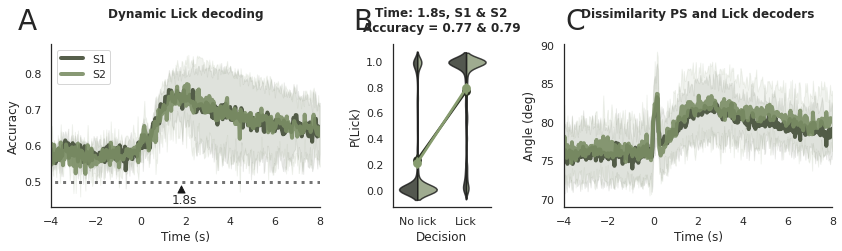

In [124]:
## Lick decoding figure
plt.rcParams['figure.figsize'] = (14, 3)
plt.subplots_adjust(wspace=0.75, hspace=0.8)
region_list = ['s1' ,'s2']
ax_acc = plt.subplot(1, 5, (1, 2))
pop.plot_interrupted_trace_simple(ax=ax_acc, time_array=new_time, plot_array=np.zeros_like(new_time) + 0.5, 
                              ccolor='k', aalpha=0.6, llinewidth=3, linest=':')
## Total average plot
pl_bool = True
for reg in region_list:
    pop.plot_interrupted_trace_average_per_mouse(ax=ax_acc,  time_array=new_time,plot_array=lick_acc, #individual_mouse_list=['J065_s1', 'J065_s2'],
                           llabel=reg.upper(), ccolor=colors_reg[reg], plot_laser=False, #pl_bool,
                           plot_std_area=True, plot_indiv=False, region_list=[reg])
    pl_bool = False
    
for tp in tp_violin:
    ax_acc.scatter([tp], [.48], marker='^', s=50, color='k')
    ax_acc.text(s=f'{tp}s', x=tp - 0.4, y=0.44)

ax_acc.set_xlabel('Time (s)'); ax_acc.set_ylabel('Accuracy')
ax_acc.legend(loc='upper left'); ax_acc.set_title('Dynamic Lick decoding', weight='bold', y=1.13);
ax_acc.set_ylim([0.43, 0.88])

for i_tp, tp in enumerate(tp_violin):
    if len(tp_violin) == 2:
        plt.subplot(2, 5, 3 + i_tp * 5)
    elif len(tp_violin) == 1:
        plt.subplot(1, 5, 3)
    plot_df = violin_df_test[tp]
    viol = sns.violinplot(data=plot_df, x='true_dec_test', y='pred_dec_test',
                   palette=[0.6 * colors_reg['s1'], 1.1 * colors_reg['s2']],
                   hue='region', split=True, inner=None, bw=0.1)
    plt.setp(viol.collections, alpha=0.8)
    sns.pointplot(data=plot_df, x='true_dec_test', y='pred_dec_test',
                   palette=[0.6 * colors_reg['s1'], 1.1 * colors_reg['s2']],
                   hue='region', label=None, linestyles=[linest_reg['s1'], linest_reg['s2']])
    accuracy_tp_s1 = pof.class_av_mean_accuracy(binary_truth=plot_df[plot_df['region'] == 'S1']['true_dec_test'],
                           estimate=plot_df[plot_df['region'] == 'S1']['pred_dec_test'])[0]
    accuracy_tp_s2 = pof.class_av_mean_accuracy(binary_truth=plot_df[plot_df['region'] == 'S2']['true_dec_test'], 
                           estimate=plot_df[plot_df['region'] == 'S2']['pred_dec_test'])[0]
    plt.title(f'Time: {tp}s, S1 & S2\nAccuracy = {np.round(accuracy_tp_s1, 2)} & {np.round(accuracy_tp_s2, 2)}', 
              weight='bold', y=1.04)
    viol.legend_.remove();
    if len(tp_violin) == 2:
        if i_tp == 1:
            plt.xlabel('Decision'); plt.ylabel('               Decoded')
        else: 
            plt.xlabel(''); plt.ylabel('P(Lick)             ')
    elif len(tp_violin) == 1:
        plt.xlabel('Decision');  plt.ylabel('P(Lick)') 
    viol.set_xticklabels(['No lick', 'Lick'])
    
ax_angle = plt.subplot(1, 5, (4, 5))
mouse_list = np.unique([ss.mouse for _, ss in sessions.items()])
region_list=['s1', 's2']
freq = 5
pl_bool = True
for reg in region_list:
    ax_angle, mean_angle_traces = pop.plot_interrupted_trace_average_per_mouse(ax=ax_angle, time_array=new_time, plot_array=angle_dec, llabel=None,
                                           plot_errorbar=False, plot_indiv=False, plot_std_area=True, region_list=[reg],
                                           plot_laser=False, #pl_bool, 
                                               ccolor=0.5 * (colors_plot[reg][0] + colors_plot[reg][1]))
    pl_bool = False
ax_angle.set_xlabel('Time (s)'); ax_angle.set_ylabel('Angle (deg)') #ax_angle.legend(loc='upper left');
ax_angle.set_title('Dissimilarity PS and Lick decoders', weight='bold', y=1.13)

## Labels:
ax_acc.text(s='A', x=-5.5, y=0.92, fontdict={'weight': 'normal', 'fontsize': 28})
ax_acc.text(s='B', x=9.5, y=0.92, fontdict={'weight': 'normal', 'fontsize': 28})
ax_acc.text(s='C', x=19, y=0.92, fontdict={'weight': 'normal', 'fontsize': 28})

ax_acc.set_xlim([-4, 8])
ax_angle.set_xlim([-4, 8])

sns.despine()
# plt.savefig('figures/decoding_licks.pdf', bbox_inches='tight')

## Difference PS & Lick decoders:

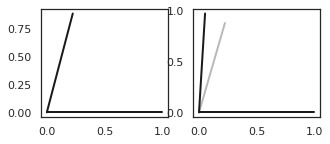

In [71]:
tmp_angle = 77 * 2 * np.pi / 360
tmp_angle3 = 87 * 2 * np.pi / 360

vec1 = np.array([1, 0])
vec2 = np.array([np.cos(tmp_angle) * vec1[0], np.sqrt(1 - np.cos(tmp_angle) * vec1[0])])
vec3 = np.array([np.cos(tmp_angle3) * vec1[0], np.sqrt(1 - np.cos(tmp_angle3) * vec1[0])])

plt.rcParams['figure.figsize'] = (5, 2)
plt.subplot(121)
plt.plot([0, vec1[0]], [0, vec1[1]], color='k', linewidth=2)
plt.plot([0, vec2[0]], [0, vec2[1]], color='k', linewidth=2)

plt.subplot(122)
plt.plot([0, vec1[0]], [0, vec1[1]], color='k', linewidth=2)
plt.plot([0, vec2[0]], [0, vec2[1]], color='k', alpha=0.3, linewidth=2)
plt.plot([0, vec3[0]], [0, vec3[1]], color='k', linewidth=2)


# Supplemental figs

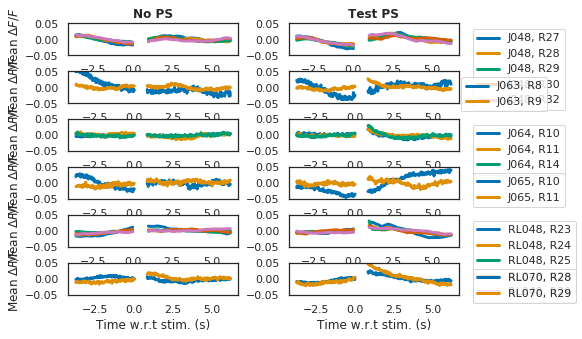

In [25]:
## Averages of all sessions:
mouse_list = np.unique([ss.mouse for _, ss in sessions.items()])

plt.subplots_adjust(wspace=0.3, hspace=0.5)
plt.rcParams['figure.figsize'] = (8, 12)
title_ps = {0: 'No PS', 1: 'Test PS', 2: '150 PS', 3: 'Run legend:'}
# mouse = mouse_list[5]
# mouse_list = mouse_list[:2]
av_axes = {}
i_ax = 0
range_ps = 2
color_index = {m: 0 for m in mouse_list}
legend_tuple = []
for i_m, mouse in enumerate(mouse_list):
    temp_session_list = [k for k, ss in sessions.items() if ss.mouse == mouse]
    for i_s in temp_session_list:
        ss = sessions[i_s]
        for i_ps in range(range_ps):
            av_axes[i_ax] = plt.subplot(len(mouse_list), range_ps, 1 + i_ps + range_ps * i_m)
            if i_ps <= 2:
                pop.plot_interrupted_trace_simple(ax=av_axes[i_ax], time_array=ss.filter_ps_time,
                                              plot_array=np.mean(ss.behaviour_trials[:, ss.photostim == i_ps, :][:, :, ss.filter_ps_array], (0, 1)), 
                                              llabel=f'{mouse}, R{ss.run_number}', ccolor=color_dict_stand[color_index[mouse]], zero_mean=True)
            if i_ps <= 1:
                av_axes[i_ax].set_ylim([-0.05, 0.05])
            if i_m == 0:
                av_axes[i_ax].set_title(title_ps[i_ps], weight='bold')
            if i_m == len(mouse_list) - 1:
                av_axes[i_ax].set_xlabel('Time w.r.t stim. (s)')
            if i_ps == 0:
                av_axes[i_ax].set_ylabel('Mean ' + r'$\Delta F / F$')
            if i_ps == range_ps - 1 and i_s == temp_session_list[-1]:
                if mouse == 'J063':
                    leg = av_axes[i_ax].legend(bbox_to_anchor=(1.55, 1))  # no clue why this needed
                else:
                    leg = av_axes[i_ax].legend(bbox_to_anchor=(1.05, 1))
                legend_tuple.append(leg)
            i_ax += 1
        color_index[mouse] += 1
legend_tuple = tuple(legend_tuple)
# plt.savefig('figures/average_all_sessions.pdf', bbox_extra_artists=legend_tuple, bbox_inches='tight')


In [262]:
## Plot overlay of means all frames & filtered frames. => manually assessed that the current frame
## filter is the minimal to filter the artefact in all sessions. But for all 5Hz but 1, it could be shorter.
## For 30Hz it can be shorter as well, probably some nice info directly post stim.

# ss = sessions[kk] 
# print(ss)
# plt.rcParams['figure.figsize'] = (9, 5)
# plt.plot(np.mean(ss.behaviour_trials[:, ss.photostim == 1, :], (0, 1)), '.-')
# plt.plot(ss.filter_ps_array, np.mean(ss.behaviour_trials[:, ss.photostim == 1, :][:, :, ss.filter_ps_array], (0, 1)), '.-')
# kk += 1

## Cross validate regularization value

Idea:
  - It depends on number of neurons. So either scale with n_neurons, but I'm not sure what scaling (e.g. linear) this is.. So instead we'll optimise per session. S1/S2 are about 50/50 so we'll ignore this (also because their perfomance varies)
  - Per session; evaluate 3 seconds post stim at 5Hz. Find the maximum test decoding accuracy (for both decoders). we'll take the corresponding C value.
  - Save in some file because this takes some time to run

In [128]:
df_prediction_train, df_prediction_test = pof.train_test_all_sessions(sessions={0: sessions[2]}, trial_times_use=np.array([1.6]), 
                                                          verbose=0, hitmiss_only=False, include_150=False,
                                                          include_autoreward=True, C_value=0.002,
                                                          train_projected=False,
                                                          neurons_selection='s1')

In [374]:
(lick_acc, lick_acc_split, ps_acc, ps_acc_split, lick_half, 
                 angle_dec, dec_weights) = pof.compute_accuracy_time_array(sessions={0: sessions[0]}, time_array=tp_dict['cv_reg'],
                                                              projected_data=False, reg_type='none',
                                                              region_list=['s1'],
                                                              average_fun=pof.class_av_mean_accuracy)

11it [00:02,  4.39it/s]


In [375]:
lick_acc

{'s1': array([[0.43898801, 0.39237748],
        [0.53889213, 0.41208448],
        [0.58342863, 0.40998501],
        [0.48905403, 0.39519298],
        [0.46592374, 0.3835686 ],
        [0.61957521, 0.41166798],
        [0.54067397, 0.39467476],
        [0.60980377, 0.39236397],
        [0.53799178, 0.37077881],
        [0.58951592, 0.36769803],
        [0.57457458, 0.37395034]])}

In [377]:
## Integrate different imaging frequencies:
assert 'mutual' in tp_dict.keys()
tp_dict['cv_reg'] = tp_dict['mutual'][np.logical_and(tp_dict['mutual'] <= 3, tp_dict['mutual'] > 0)]  # Use all time points < 3 post stim
c_value_array = np.array([50, 20, 5, 2, 0.5, 0.2, 0.05, 0.02, 0.005, 0.002])  # list of C values, where 1/C is reg strength

def perform_logreg_cv(sessions, c_value_array, reg_list=['s1', 's2']):
    """Takes max over regions if both are given"""
    max_acc_scores = {}
    for key, ss in sessions.items():
        print(ss)
        ## First without reg:
        max_dec_values = np.zeros((len(c_value_array) + 1, 2))
        (lick_acc, lick_acc_split, ps_acc, ps_acc_split, lick_half, 
                 angle_dec, dec_weights) = pof.compute_accuracy_time_array(sessions={0: ss}, time_array=tp_dict['cv_reg'],
                                                              projected_data=False, reg_type='none',
                                                              region_list=reg_list,
                                                              average_fun=pof.class_av_mean_accuracy)
        assert len(lick_acc) == 1
        mr_name = list(lick_acc.keys())[0]
        max_lick_dec = np.max(lick_acc[mr_name])  #np.max([np.max(reg_acc[:, 0]) for _, reg_acc in lick_acc.items()])
        max_ps_dec = np.max(ps_acc[mr_name])  #np.max([np.max(reg_acc[:, 0]) for _, reg_acc in ps_acc.items()])
        max_dec_values[0, :] = max_lick_dec.copy(), max_ps_dec.copy()  
        ## Then with varying reg strengths:
        for i_c, c_value in enumerate(c_value_array):
            ## Compute results
            (lick_acc, lick_acc_split, ps_acc, ps_acc_split, lick_half, 
                 angle_dec, dec_weights) = pof.compute_accuracy_time_array(sessions={0: ss}, time_array=tp_dict['cv_reg'],
                                                              projected_data=False, 
                                                              reg_type='l2', regularizer=c_value,
                                                              region_list=reg_list,
                                                              average_fun=pof.class_av_mean_accuracy)
            assert len(lick_acc) == 1
#             mr_name = list(lick_acc.keys())[0]
            max_lick_dec = np.max(lick_acc[reg][:, 0]) # np.max(lick_acc[mr_name])  #np.max([np.max(reg_acc[:, 0]) for _, reg_acc in lick_acc.items()])
            max_ps_dec = np.max(ps_acc[reg][:, 0]) #np.max(ps_acc[mr_name])  #np.max([np.max(reg_acc[:, 0]) for _, reg_acc in ps_acc.items()])
            max_dec_values[i_c + 1, :] = max_lick_dec.copy(), max_ps_dec.copy()
        ## Save:
        max_acc_scores[key] = max_dec_values.copy()
    return max_acc_scores
    
dict_cv_results = {}
for reg in ['s1', 's2']:
    print(f'---------------\n{reg}\n-------------\n')
    dict_cv_results[reg] = perform_logreg_cv(sessions=sessions, 
                                             c_value_array=c_value_array, 
                                             reg_list=[reg])

0it [00:00, ?it/s]

---------------
s1
-------------

Mouse RL070, run 28


11it [00:02,  4.04it/s]
11it [00:03,  3.26it/s]
11it [00:03,  3.39it/s]
11it [00:03,  3.39it/s]
11it [00:03,  3.36it/s]
11it [00:03,  3.49it/s]
11it [00:03,  3.55it/s]
11it [00:03,  3.39it/s]
11it [00:03,  3.63it/s]
11it [00:02,  3.75it/s]
11it [00:02,  3.88it/s]
0it [00:00, ?it/s]

Mouse RL070, run 29


11it [00:02,  4.84it/s]
11it [00:02,  4.16it/s]
11it [00:02,  4.30it/s]
11it [00:02,  4.15it/s]
11it [00:02,  4.38it/s]
11it [00:02,  4.46it/s]
11it [00:02,  4.63it/s]
11it [00:02,  4.96it/s]
11it [00:02,  5.16it/s]
11it [00:02,  5.32it/s]
11it [00:02,  5.50it/s]
1it [00:00,  7.46it/s]

Mouse J048, run 27


11it [00:01,  7.40it/s]
11it [00:01,  5.62it/s]
11it [00:01,  5.66it/s]
11it [00:01,  5.71it/s]
11it [00:01,  5.65it/s]
11it [00:01,  5.79it/s]
11it [00:01,  5.90it/s]
11it [00:01,  6.23it/s]
11it [00:01,  6.49it/s]
11it [00:01,  7.24it/s]
11it [00:01,  7.97it/s]
1it [00:00,  6.91it/s]

Mouse J048, run 28


11it [00:01,  6.85it/s]
11it [00:02,  5.41it/s]
11it [00:02,  5.34it/s]
11it [00:02,  5.34it/s]
11it [00:02,  5.26it/s]
11it [00:02,  5.36it/s]
11it [00:01,  5.56it/s]
11it [00:01,  5.70it/s]
11it [00:01,  6.01it/s]
11it [00:01,  6.88it/s]
11it [00:01,  6.93it/s]
1it [00:00,  5.77it/s]

Mouse J048, run 29


11it [00:01,  5.78it/s]
11it [00:03,  3.54it/s]
11it [00:03,  3.50it/s]
11it [00:03,  3.37it/s]
11it [00:03,  3.38it/s]
11it [00:03,  3.40it/s]
11it [00:03,  3.38it/s]
11it [00:02,  4.34it/s]
11it [00:02,  4.85it/s]
11it [00:02,  5.48it/s]
11it [00:02,  5.46it/s]
1it [00:00,  6.08it/s]

Mouse J048, run 30


11it [00:01,  6.11it/s]
11it [00:02,  4.04it/s]
11it [00:03,  3.17it/s]
11it [00:03,  3.15it/s]
11it [00:03,  3.18it/s]
11it [00:02,  3.70it/s]
11it [00:02,  4.42it/s]
11it [00:02,  4.75it/s]
11it [00:02,  5.01it/s]
11it [00:01,  5.92it/s]
11it [00:01,  6.32it/s]
1it [00:00,  5.73it/s]

Mouse J048, run 32


11it [00:01,  5.75it/s]
11it [00:02,  3.83it/s]
11it [00:02,  3.76it/s]
11it [00:03,  3.22it/s]
11it [00:02,  3.80it/s]
11it [00:03,  3.51it/s]
11it [00:02,  3.69it/s]
11it [00:02,  4.03it/s]
11it [00:02,  4.12it/s]
11it [00:02,  5.02it/s]
11it [00:02,  5.34it/s]
1it [00:00,  7.34it/s]

Mouse J064, run 10


11it [00:01,  7.68it/s]
11it [00:01,  5.66it/s]
11it [00:01,  5.79it/s]
11it [00:01,  5.78it/s]
11it [00:01,  5.77it/s]
11it [00:01,  6.12it/s]
11it [00:01,  6.43it/s]
11it [00:01,  7.30it/s]
11it [00:01,  7.79it/s]
11it [00:01,  8.39it/s]
11it [00:01,  8.47it/s]
1it [00:00,  6.12it/s]

Mouse J064, run 11


11it [00:01,  6.21it/s]
11it [00:02,  4.98it/s]
11it [00:02,  4.99it/s]
11it [00:02,  4.69it/s]
11it [00:02,  4.60it/s]
11it [00:02,  5.17it/s]
11it [00:02,  5.30it/s]
11it [00:01,  5.69it/s]
11it [00:01,  5.98it/s]
11it [00:01,  6.45it/s]
11it [00:01,  6.55it/s]
0it [00:00, ?it/s]

Mouse J064, run 14


11it [00:02,  5.01it/s]
11it [00:02,  4.16it/s]
11it [00:02,  4.14it/s]
11it [00:02,  4.12it/s]
11it [00:02,  4.14it/s]
11it [00:02,  4.21it/s]
11it [00:02,  4.34it/s]
11it [00:02,  4.65it/s]
11it [00:02,  4.82it/s]
11it [00:02,  5.10it/s]
11it [00:02,  5.22it/s]
2it [00:00, 11.18it/s]

Mouse J063, run 8


11it [00:00, 12.64it/s]
11it [00:01,  9.13it/s]
11it [00:01,  8.98it/s]
11it [00:01,  9.56it/s]
11it [00:01, 10.06it/s]
11it [00:00, 11.12it/s]
11it [00:00, 12.45it/s]
11it [00:00, 14.04it/s]
11it [00:00, 14.84it/s]
11it [00:00, 14.97it/s]
11it [00:00, 15.04it/s]
1it [00:00,  6.19it/s]

Mouse J063, run 9


11it [00:01,  6.41it/s]
11it [00:02,  5.30it/s]
11it [00:02,  5.27it/s]
11it [00:02,  5.29it/s]
11it [00:02,  5.32it/s]
11it [00:02,  5.34it/s]
11it [00:01,  5.59it/s]
11it [00:01,  6.03it/s]
11it [00:01,  6.48it/s]
11it [00:01,  6.94it/s]
11it [00:01,  6.91it/s]
1it [00:00,  5.25it/s]

Mouse RL048, run 23


11it [00:02,  5.43it/s]
11it [00:02,  3.91it/s]
11it [00:03,  3.59it/s]
11it [00:02,  3.92it/s]
11it [00:02,  4.04it/s]
11it [00:02,  3.88it/s]
11it [00:02,  4.18it/s]
11it [00:02,  4.23it/s]
11it [00:02,  4.67it/s]
11it [00:02,  4.86it/s]
11it [00:02,  4.95it/s]
1it [00:00,  5.81it/s]

Mouse RL048, run 24


11it [00:02,  5.14it/s]
11it [00:02,  4.04it/s]
11it [00:02,  4.34it/s]
11it [00:02,  4.45it/s]
11it [00:02,  4.43it/s]
11it [00:02,  4.50it/s]
11it [00:02,  4.70it/s]
11it [00:02,  4.44it/s]
11it [00:02,  5.16it/s]
11it [00:02,  5.48it/s]
11it [00:01,  5.83it/s]
0it [00:00, ?it/s]

Mouse RL048, run 25


11it [00:03,  3.63it/s]
11it [00:04,  2.57it/s]
11it [00:03,  2.76it/s]
11it [00:04,  2.65it/s]
11it [00:03,  2.91it/s]
11it [00:03,  2.88it/s]
11it [00:03,  2.89it/s]
11it [00:03,  3.15it/s]
11it [00:03,  2.83it/s]
11it [00:03,  2.88it/s]
11it [00:03,  3.03it/s]
0it [00:00, ?it/s]

Mouse RL048, run 28


11it [00:03,  3.25it/s]
11it [00:04,  2.27it/s]
11it [00:04,  2.36it/s]
11it [00:04,  2.50it/s]
11it [00:04,  2.48it/s]
11it [00:03,  2.82it/s]
11it [00:04,  2.71it/s]
11it [00:03,  3.33it/s]
11it [00:03,  3.34it/s]
11it [00:03,  3.61it/s]
11it [00:02,  3.89it/s]
0it [00:00, ?it/s]

Mouse RL048, run 29


11it [00:02,  4.93it/s]
11it [00:02,  3.69it/s]
11it [00:03,  3.57it/s]
11it [00:03,  3.36it/s]
11it [00:03,  3.51it/s]
11it [00:02,  3.89it/s]
11it [00:02,  4.04it/s]
11it [00:02,  3.81it/s]
11it [00:02,  4.71it/s]
11it [00:02,  4.60it/s]
11it [00:01,  5.56it/s]
1it [00:00,  8.24it/s]

Mouse J065, run 10


11it [00:01,  9.28it/s]
11it [00:02,  5.47it/s]
11it [00:01,  5.73it/s]
11it [00:01,  6.28it/s]
11it [00:01,  7.09it/s]
11it [00:01,  8.88it/s]
11it [00:01, 10.52it/s]
11it [00:00, 11.72it/s]
11it [00:00, 12.42it/s]
11it [00:00, 12.80it/s]
11it [00:00, 12.79it/s]
1it [00:00,  7.82it/s]

Mouse J065, run 11


11it [00:01,  7.75it/s]
11it [00:01,  6.07it/s]
11it [00:01,  6.03it/s]
11it [00:01,  6.01it/s]
11it [00:01,  5.92it/s]
11it [00:01,  6.31it/s]
11it [00:01,  6.63it/s]
11it [00:01,  7.28it/s]
11it [00:01,  7.75it/s]
11it [00:01,  8.07it/s]
11it [00:01,  8.37it/s]
0it [00:00, ?it/s]

---------------
s2
-------------

Mouse RL070, run 28


11it [00:02,  4.61it/s]
11it [00:03,  3.47it/s]
11it [00:03,  3.17it/s]
11it [00:03,  3.21it/s]
11it [00:03,  3.00it/s]
11it [00:03,  3.58it/s]
11it [00:02,  3.67it/s]
11it [00:02,  4.13it/s]
11it [00:02,  4.35it/s]
11it [00:02,  4.72it/s]
11it [00:02,  4.84it/s]
1it [00:00,  5.23it/s]

Mouse RL070, run 29


11it [00:02,  5.35it/s]
11it [00:02,  4.56it/s]
11it [00:02,  4.66it/s]
11it [00:02,  4.66it/s]
11it [00:02,  4.75it/s]
11it [00:02,  4.94it/s]
11it [00:02,  5.14it/s]
11it [00:01,  5.50it/s]
11it [00:01,  5.72it/s]
11it [00:01,  6.08it/s]
11it [00:01,  6.08it/s]
1it [00:00,  6.99it/s]

Mouse J048, run 27


11it [00:01,  7.05it/s]
11it [00:02,  5.32it/s]
11it [00:02,  5.26it/s]
11it [00:02,  5.24it/s]
11it [00:02,  5.21it/s]
11it [00:02,  5.40it/s]
11it [00:01,  5.56it/s]
11it [00:01,  5.92it/s]
11it [00:01,  6.36it/s]
11it [00:01,  7.17it/s]
11it [00:01,  7.41it/s]
1it [00:00,  6.72it/s]

Mouse J048, run 28


11it [00:01,  6.65it/s]
11it [00:02,  5.20it/s]
11it [00:02,  5.15it/s]
11it [00:02,  5.11it/s]
11it [00:02,  5.05it/s]
11it [00:02,  5.15it/s]
11it [00:02,  5.36it/s]
11it [00:01,  5.63it/s]
11it [00:01,  5.99it/s]
11it [00:01,  6.58it/s]
11it [00:01,  6.81it/s]
1it [00:00,  5.76it/s]

Mouse J048, run 29


11it [00:02,  5.48it/s]
11it [00:03,  3.55it/s]
11it [00:03,  3.41it/s]
11it [00:03,  3.46it/s]
11it [00:03,  3.56it/s]
11it [00:03,  3.16it/s]
11it [00:03,  3.07it/s]
11it [00:03,  3.61it/s]
11it [00:02,  4.04it/s]
11it [00:02,  4.38it/s]
11it [00:02,  5.12it/s]
0it [00:00, ?it/s]

Mouse J048, run 30


11it [00:02,  4.44it/s]
11it [00:02,  3.82it/s]
11it [00:03,  3.52it/s]
11it [00:02,  3.78it/s]
11it [00:03,  3.23it/s]
11it [00:03,  3.29it/s]
11it [00:03,  3.37it/s]
11it [00:02,  4.43it/s]
11it [00:02,  4.46it/s]
11it [00:02,  4.87it/s]
11it [00:02,  5.09it/s]
1it [00:00,  5.56it/s]

Mouse J048, run 32


11it [00:02,  5.14it/s]
11it [00:02,  3.80it/s]
11it [00:02,  3.95it/s]
11it [00:03,  3.61it/s]
11it [00:02,  3.84it/s]
11it [00:02,  3.70it/s]
11it [00:02,  4.18it/s]
11it [00:02,  4.32it/s]
11it [00:02,  5.07it/s]
11it [00:01,  5.67it/s]
11it [00:02,  4.95it/s]
1it [00:00,  6.34it/s]

Mouse J064, run 10


11it [00:01,  7.76it/s]
11it [00:01,  5.92it/s]
11it [00:01,  5.66it/s]
11it [00:01,  5.95it/s]
11it [00:01,  6.09it/s]
11it [00:01,  6.49it/s]
11it [00:01,  6.87it/s]
11it [00:01,  7.68it/s]
11it [00:01,  8.15it/s]
11it [00:01,  8.55it/s]
11it [00:01,  8.57it/s]
1it [00:00,  6.42it/s]

Mouse J064, run 11


11it [00:01,  6.67it/s]
11it [00:02,  5.32it/s]
11it [00:02,  5.27it/s]
11it [00:02,  5.31it/s]
11it [00:02,  5.40it/s]
11it [00:01,  5.57it/s]
11it [00:01,  5.83it/s]
11it [00:01,  6.28it/s]
11it [00:01,  6.64it/s]
11it [00:01,  7.13it/s]
11it [00:01,  7.21it/s]
1it [00:00,  5.23it/s]

Mouse J064, run 14


11it [00:02,  5.17it/s]
11it [00:02,  4.20it/s]
11it [00:02,  4.20it/s]
11it [00:02,  4.26it/s]
11it [00:02,  4.29it/s]
11it [00:02,  4.38it/s]
11it [00:02,  4.51it/s]
11it [00:02,  5.01it/s]
11it [00:02,  5.25it/s]
11it [00:01,  5.63it/s]
11it [00:01,  5.57it/s]
2it [00:00, 11.12it/s]

Mouse J063, run 8


11it [00:00, 11.74it/s]
11it [00:01,  9.12it/s]
11it [00:01,  8.91it/s]
11it [00:01,  9.70it/s]
11it [00:01, 10.13it/s]
11it [00:00, 11.36it/s]
11it [00:00, 12.46it/s]
11it [00:00, 13.98it/s]
11it [00:00, 14.50it/s]
11it [00:00, 14.77it/s]
11it [00:00, 14.88it/s]
1it [00:00,  5.37it/s]

Mouse J063, run 9


11it [00:02,  5.33it/s]
11it [00:02,  4.34it/s]
11it [00:02,  4.31it/s]
11it [00:02,  4.35it/s]
11it [00:02,  4.42it/s]
11it [00:02,  4.54it/s]
11it [00:02,  4.71it/s]
11it [00:02,  5.14it/s]
11it [00:02,  5.36it/s]
11it [00:01,  5.78it/s]
11it [00:01,  5.85it/s]
0it [00:00, ?it/s]

Mouse RL048, run 23


11it [00:02,  4.95it/s]
11it [00:02,  3.91it/s]
11it [00:02,  3.98it/s]
11it [00:02,  4.16it/s]
11it [00:02,  4.15it/s]
11it [00:02,  4.31it/s]
11it [00:02,  4.09it/s]
11it [00:02,  4.73it/s]
11it [00:02,  4.83it/s]
11it [00:02,  5.37it/s]
11it [00:02,  5.42it/s]
1it [00:00,  6.14it/s]

Mouse RL048, run 24


11it [00:01,  5.70it/s]
11it [00:02,  4.41it/s]
11it [00:02,  4.64it/s]
11it [00:02,  4.58it/s]
11it [00:02,  4.14it/s]
11it [00:02,  3.68it/s]
11it [00:02,  3.74it/s]
11it [00:02,  3.97it/s]
11it [00:02,  5.28it/s]
11it [00:01,  5.59it/s]
11it [00:02,  4.91it/s]
0it [00:00, ?it/s]

Mouse RL048, run 25


11it [00:03,  3.02it/s]
11it [00:04,  2.65it/s]
11it [00:04,  2.60it/s]
11it [00:04,  2.70it/s]
11it [00:03,  2.88it/s]
11it [00:03,  2.84it/s]
11it [00:03,  3.00it/s]
11it [00:03,  3.20it/s]
11it [00:03,  3.44it/s]
11it [00:03,  3.28it/s]
11it [00:03,  3.48it/s]
0it [00:00, ?it/s]

Mouse RL048, run 28


11it [00:02,  3.95it/s]
11it [00:03,  2.81it/s]
11it [00:03,  3.08it/s]
11it [00:03,  3.08it/s]
11it [00:03,  3.05it/s]
11it [00:03,  2.99it/s]
11it [00:03,  3.14it/s]
11it [00:03,  3.03it/s]
11it [00:02,  3.76it/s]
11it [00:02,  3.89it/s]
11it [00:03,  3.54it/s]
0it [00:00, ?it/s]

Mouse RL048, run 29


11it [00:02,  4.94it/s]
11it [00:02,  3.92it/s]
11it [00:02,  3.98it/s]
11it [00:02,  4.04it/s]
11it [00:02,  4.10it/s]
11it [00:02,  4.02it/s]
11it [00:02,  4.37it/s]
11it [00:02,  4.75it/s]
11it [00:02,  4.93it/s]
11it [00:02,  4.60it/s]
11it [00:02,  4.74it/s]
1it [00:00,  7.36it/s]

Mouse J065, run 10


11it [00:01,  9.75it/s]
11it [00:02,  5.16it/s]
11it [00:01,  5.53it/s]
11it [00:01,  6.80it/s]
11it [00:01,  8.22it/s]
11it [00:01, 10.31it/s]
11it [00:00, 11.58it/s]
11it [00:00, 13.10it/s]
11it [00:00, 13.53it/s]
11it [00:00, 13.76it/s]
11it [00:00, 14.40it/s]
1it [00:00,  8.32it/s]

Mouse J065, run 11


11it [00:01,  8.24it/s]
11it [00:01,  6.42it/s]
11it [00:01,  6.43it/s]
11it [00:01,  6.53it/s]
11it [00:01,  6.59it/s]
11it [00:01,  6.92it/s]
11it [00:01,  7.44it/s]
11it [00:01,  8.25it/s]
11it [00:01,  8.57it/s]
11it [00:01,  9.09it/s]
11it [00:01,  9.27it/s]


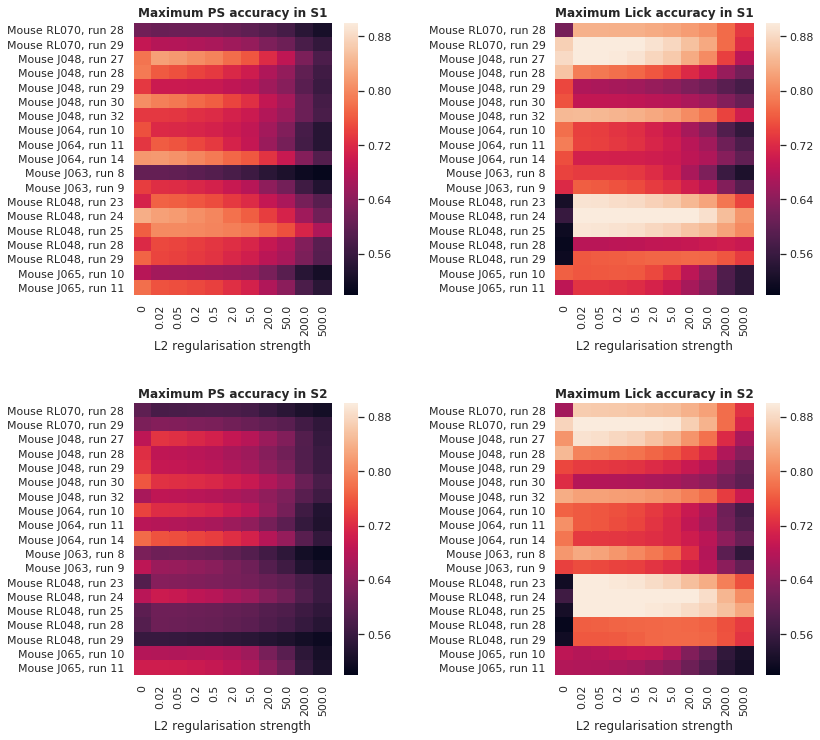

In [388]:
plt.rcParams['figure.figsize'] = (12, 12)
plt.subplots_adjust(wspace=0.7, hspace=0.4)

for i_reg, reg in enumerate(['s1', 's2']):
    max_acc_scores = dict_cv_results[reg]
    n_sessions = len(max_acc_scores)
    n_cvalues = max_acc_scores[0].shape[0]
    dict_max_acc_all = {xx: np.zeros((n_sessions, n_cvalues)) for xx in ['PS', 'Lick']}
    for key, acc in max_acc_scores.items():
        dict_max_acc_all['Lick'][key, :] = acc[:, 0]
        dict_max_acc_all['PS'][key, :] = acc[:, 1]

    c_labels = [0] + [1/c for c in c_value_array]
    ss_labels = [str(ss) for key, ss in sessions.items()]

    for i_plot, xx in enumerate(['PS', 'Lick']):
        plt.subplot(2, 2, i_plot + 1 + (i_reg * 2))
        ax1 = sns.heatmap(dict_max_acc_all[xx], xticklabels=c_labels, yticklabels=ss_labels, vmin=0.5, vmax=0.9)
    #     plt.xlabel('1/C value of L2 regularisation'); plt.title(f'Maximum {xx} test accuracy during 3 seconds post-stim')
        plt.xlabel('L2 regularisation strength'); plt.title(f'Maximum {xx} accuracy in {reg.upper()}', weight='bold')

        bottom, top = ax1.get_ylim()
        ax1.set_ylim(bottom + 0.5, top - 0.5)

plt.savefig('figures/optimise_regularisation.pdf', bbox_inches='tight')

In [91]:
def create_df_table_details(sessions):
    """Create Dataframe table with details of sessions."""
    n_sessions = len(sessions)
    column_names = ['Mouse', 'Run', 'f (Hz)', #'# Imaging planes',
                    r"$N$" + 'S1', r"$N$" + 'S2',
                    'Trials', 'Hit', 'FP', 'Miss', 'CR', 'UR Hit', 'AR Miss', 'Too early']
    dict_details = {cc: np.zeros(n_sessions, dtype='object') for cc in column_names}
    for key, ss in sessions.items():
        dict_details['Mouse'][key] = ss.mouse
        dict_details['Run'][key] = ss.run_number
        dict_details['f (Hz)'][key] = ss.frequency
#         dict_details['# Imaging planes'][key] = len(np.unique(ss.plane_number))
        dict_details[r"$N$" + 'S1'][key] = np.sum(ss.s1_bool)
        dict_details[r"$N$" + 'S2'][key] = np.sum(ss.s2_bool)
        leave_out_150_inds = ss.photostim < 2
        dict_details['Trials'][key] = len(ss.outcome[leave_out_150_inds])
        print(ss.name, ss.n_trials, len(ss.outcome))
        dict_details['Hit'][key] = np.sum(ss.outcome[leave_out_150_inds] == 'hit')
        dict_details['FP'][key] = np.sum(ss.outcome[leave_out_150_inds] == 'fp')
        dict_details['Miss'][key] = np.sum(np.logical_and(ss.outcome[leave_out_150_inds] == 'miss',
                                                          ss.autorewarded[leave_out_150_inds] == False))
        dict_details['CR'][key] = np.sum(ss.outcome[leave_out_150_inds] == 'cr')
        dict_details['Too early'][key] = np.sum(ss.outcome[leave_out_150_inds] == 'too_')
        dict_details['UR Hit'][key] = np.sum(ss.unrewarded_hits[leave_out_150_inds])
        dict_details['AR Miss'][key] = np.sum(ss.autorewarded[leave_out_150_inds])
        assert np.sum([dict_details[xx][key] for xx in ['Hit', 'FP', 'Miss', 'CR', 'Too early', 'AR Miss']]) == dict_details['Trials'][key], 'total number of trials is not correct'
    df_details = pd.DataFrame(dict_details)
    df_details = df_details.sort_values(by=['Mouse', 'Run'])
    df_details = df_details.reset_index()
    del df_details['index']
    return df_details

df_details = create_df_table_details(sessions=sessions)
df_details
# df_details.to_latex(index=False)  # print latex Tabular code

Mouse J065, run 11 165 165
Mouse J063, run 9 170 170
Mouse J064, run 10 132 132
Mouse J064, run 11 140 140
Mouse J064, run 14 179 179
Mouse RL070, run 28 315 315
Mouse RL070, run 29 197 197


,Mouse,Run,f (Hz),$N$S1,$N$S2,Trials,Hit,FP,Miss,CR,UR Hit,AR Miss,Too early
0,J063,9,30,329,275,109,17,18,28,39,0,2,5
1,J064,10,30,295,129,95,25,23,13,25,2,1,8
2,J064,11,30,481,190,88,16,13,17,27,0,2,13
3,J064,14,30,537,203,122,30,24,20,30,0,3,15
4,J065,11,30,161,111,104,25,36,7,18,1,3,15
5,RL070,28,30,296,196,215,16,1,74,105,2,19,0
6,RL070,29,30,363,224,129,28,12,25,53,2,6,5


In [88]:
print(ss.name)
print('n trials', ss.n_trials, len(ss.autorewarded))
print(np.sum(ss.autorewarded), np.sum(ss.unrewarded_hits))

Mouse RL070, run 29
n trials 197 197
10 3


197

In [89]:
np.unique(ss.outcome)

array(['cr', 'fp', 'hit', 'miss', 'too_'], dtype='<U4')

In [68]:
df_details[r"$N$" + 'S2'].sum() + df_details[r"$N$" + 'S1'].sum()

29187

In [48]:
# np.sum(sessions[14].unrewarded_hits)
print('FIRST LICK TIMES FOR UR HITS FOR ALL SESSIONS\n')
for i_ss, sess in sessions.items():
    print(sess, '\n')
#     print('ratio UR hit / AR miss',
#           np.sum(np.logical_and(sess.autorewarded, sess.unrewarded_hits)) / np.sum(sess.autorewarded))
    for ii, triall in enumerate(sess.nonnan_trials):
        if sess.unrewarded_hits[ii]:
            print('UH', sess.run.spiral_licks[triall][0])
    #     elif sessions[14].outcome[ii] == 'hit':
    #         print('H', sess.run.spiral_licks[triall][0])
    print('-------------------------------\n')

FIRST LICK TIMES FOR UR HITS FOR ALL SESSIONS

Mouse RL070, run 28 

UH 967.2202502723667
UH 994.75
UH 989.4000000001397
UH 991.2765059994999
UH 951.6271533207037
UH 969.2000000001863
UH 989.8909797738306
-------------------------------

Mouse RL070, run 29 

UH 993.1500000001397
UH 921.5611619639676
UH 926.8307310668752
-------------------------------

Mouse J048, run 27 

-------------------------------

Mouse J048, run 28 

UH 958.1242618635297
UH 535.8772456496954
UH 247.9604297450278
UH 811.422656874638
UH 239.5231502437964
UH 978.9755813567899
-------------------------------

Mouse J048, run 29 

UH 990.3579204715788
UH 980.680505358614
UH 999.9715536106378
-------------------------------

Mouse J048, run 30 

UH 994.827018218115
-------------------------------

Mouse J048, run 32 

-------------------------------

Mouse J064, run 10 

UH 984.8809245786979
UH 860.4174517517677
UH 971.3500000000931
UH 934.6500000003725
UH 813.1000000005588
UH 963.4400350493379
--------------------

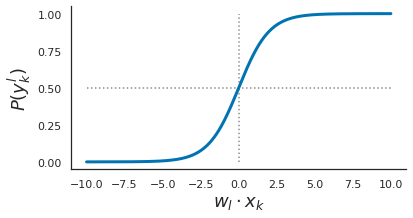

In [54]:
plt.rcParams['figure.figsize'] = (6, 3)
plt.rcParams['font.size'] = 20
tmp = plt.subplot(111)
x_array = np.linspace(-10, 10, 601)
y_array = 1 / (1 + np.exp(-1 * x_array))
tmp.plot([0, 0], [0, 1], color='k', alpha=0.5, linestyle=':')
tmp.plot([-10, 10], [0.5, 0.5], color='k', alpha=0.5, linestyle=':')
tmp.plot(x_array, y_array, linewidth=3)
tmp.set_xlabel(r"$w_l \cdot x_k$", fontdict={'fontsize': 18})
tmp.set_ylabel(r"$P(y_k^l)$", fontdict={'fontsize': 18})
tmp.set_yticks(np.array([0, 0.25, 0.5, 0.75, 1]))
sns.despine()

In [32]:
tmp

## ideas to improve / directions to go

#### Current plot:

- Distribution weight matrix
- plot \Delta W(t, t-1)

#### Try to find a function of the data that enhances the readout.

- Dimensionality reduction (dPCA should be ideal, theoretically)


#### S1 / S2 comparison

- Add dynamic prediction between populations -> subspaces -> Same question as with semedo data (i.e. different neurons that predict S2 or decode stim)

- Use increasing/decreasing number of neurons